<div style="display: flex; justify-content: flex-end; align-items: center;">
    <div style="width: 30%; text-align: right; margin-right: 20px;">
        <img src="https://medicinaprecisionandalucia.iavante.es/pluginfile.php/1/theme_edumy/headerlogo1/1702978814/logo-web-fps-718x150%20v2%20copia.png" alt="Web Fundación Progreso y Salud" style="width: 100%;"/>
    </div>
    <div style="width: 60%; margin-right: 1em;">
        <p style="text-align: right; font-weight: bold; font-size: 2em; margin-top: 30px;">
            Table1 and models
        </p>
        <p style="text-align: right; color: #666">
            Proyect: EII
        </p>
        <p style="text-align: right; color: #666">
            Ahmed Bouallou | Juan Luis González Rodríguez
        </p>
    </div>
</div>

Perform a subgroup analysis of the aforementioned objectives based on the drug used and maintenance dosage, associated immunosuppressants and the characteristics of age at diagnosis and drug levels.

Important to note: in this initial phase, we are only use two biological drugs in our dataset: USTEKINUMAB & VEDOLIZUMAB


## 1.Libraries

In [150]:
# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Import the necessary libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import shap
from summarytools import dfSummary
from sklearn.model_selection import train_test_split,  RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from tableone import TableOne
from fairlearn.metrics import MetricFrame
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from scipy.stats import shapiro
from xgboost import XGBClassifier
import xgboost as xgb
import os


The next step will be to load our dataset into the notebook:

In [151]:
# Replace 'C:\..."" with the path to your actual CSV file
df = pd.read_excel("./data/Base_uste_vedo_anonimizada.xlsx")

# There are spaces in columnames encodes as \xa0, fix them
df.columns = df.columns.str.replace('\xa0', ' ')

## 2.Exploratory Data Analysis

In [152]:
for x in df.columns: print(x)

ID
fecha_INCIO_fac
MES
YEAR
FECHA
fecha_diag
pa
sex
0_ninguno; 1_1º grado; 2_2º grado
1_ileal; 2_colónica; 3_ileocolónica; 4_ileocolónica + superior; 5_ileal + superior
1_inflamatorip;2_estenosante;3_fistulizante
1_proctitis;2_colitis izquierda; 3_pancolitis
Tipo EII
Perianal
Naïve
BIO_previo
TNF_previo
ADA_previo
IFX_previo
USTE_previo
VEDO_previo
TOFA_previo
Certol_previo
Golim_previo
Cx_previa_EII
Cx_ concurrente
Tabaco
MEIS
MEIS: 1_espondiloartropatías; 2_uveitis, epiescleritis; 3_eritema_nodoso; 4_pioderma gangrenoso; 5_colangitis esclerosanteprimaria; 6_estomatitis aftosa; 7_SdSweet; 8_psoriasis; 9_hidrosiadenitis supuratina; 10_vasculitis; 11_vitiligo; 12_ osteoporosis; 13_fenom_tromboembolico
MEIS_TOTALES
MEIS: 1_espondiloartropatías
2_uveitis
3_eritema_nodoso
4_pioderma gangrenoso
5_colangitis esclerosanteprimaria
6_estomatitis aftosa
7_SdSweet
8_psoriasis
9_hidrosiadenitis
10_vasculitis
11_vitiligo
12_ osteoporosis
13_fenom_tromboembolico
CPF_52
PCR_52
Resp_clin_06
Resp_clin_

Keep vairables following clinical criteria.

In [153]:
vars2keep = ['pa',
             'sex',
             '0_ninguno; 1_1º grado; 2_2º grado',
             '1_ileal; 2_colónica; 3_ileocolónica; 4_ileocolónica + superior; 5_ileal + superior',
             '1_inflamatorip;2_estenosante;3_fistulizante',
             '1_proctitis;2_colitis izquierda; 3_pancolitis',
             'Tipo EII',
             'TNF_previo',
             'USTE_previo',
             'VEDO_previo',
             'Tabaco',
             'MEIS',
             'Edad_inicio_F',
             'Años_enfermedad',
             'Corticoides 12 meses previo a inicio tratamiento',
             'DIABETES',
             'ASMA',
             'MIGRAÑA',
             'Calprotectina (heces)',
             'Velocidad de sedimentación globular',
             'Proteínas totales',
             'Vitamina B12',
             'Creatinina',
             'Proteína C reactiva',
             'Linfocitos (recuento)',
             'Leucocitos (recuento)',
             'Resp_clin_06',
             'Resp_clin_50',
             'Rem_clin_50'
             ]

df = df[vars2keep]

In [154]:
variables_renamer = {
    "ID": "id",
    "fecha_INCIO_fac": "start_date_drug",
    "pa": "active_ingredient",
    "sex": "sex",
    "0_ninguno; 1_1º grado; 2_2º grado": "family_ibd_degree",
    "1_ileal; 2_colónica; 3_ileocolónica; 4_ileocolónica + superior; 5_ileal + superior": "crohn_location",
    "1_inflamatorip;2_estenosante;3_fistulizante": "crohn_behavior",
    "1_proctitis;2_colitis izquierda; 3_pancolitis": "uc_extension",
    "Tipo EII": "ibd_type",
    "Perianal": "perianal",
    "Naïve": "naive",
    "ADA_previo": "previous_ada",
    "IFX_previo": "previous_ifx",
    "USTE_previo": "previous_uste",
    "VEDO_previo": "previous_vedo",
    "TOFA_previo": "previous_tofa",
    'TNF_previo': 'previous_tnf',
    "Certol_previo": "previous_certol",
    "Golim_previo": "previous_golim",
    "Cx_previa_EII": "previous_ibd_surgery",
    "Tabaco": "smoker",
    "MEIS": "meis",
    "MEIS: 1_espondiloartropatías": "meis_spondyloarthropathies",
    "2_uveitis": "meis_uveitis",
    "3_eritema_nodoso": "meis_erythema_nodosum",
    "4_pioderma gangrenoso": "meis_pyoderma_gangrenosum",
    "5_colangitis esclerosanteprimaria": "meis_primary_sclerosing_cholangitis",
    "6_estomatitis aftosa": "meis_aphthous_stomatitis",
    "7_SdSweet": "meis_sweet_syndrome",
    "8_psoriasis": "meis_psoriasis",
    "9_hidrosiadenitis": "meis_hidrosadenitis",
    "10_vasculitis": "meis_vasculitis",
    "11_vitiligo": "meis_vitiligo",
    "12_ osteoporosis": "meis_osteoporosis",
    "13_fenom_tromboembolico": "meis_thromboembolic_phenomenon",
    "Resp_clin_06": "clinical_response_26",
    "Resp_clin_50": "clinical_response_52",
    "Rem_clin_50": "clinical_remission_52",
    "Edad_inicio_F": "age_at_start_drug",
    "Años_enfermedad": "years_with_disease",
    "Corticoides 12 meses previo a inicio tratamiento": "corticosteroids_12_months_prior_to_treatment",
    "DIABETES": "diabetes",
    "ASMA": "asthma",
    "MIGRAÑA": "migraine",
    "Calprotectina (heces)": "fecal_calprotectin",
    "Velocidad de sedimentación globular": "erythrocyte_sedimentation_rate",
    "Sodio": "sodium",
    "Aspartato transaminasa": "aspartate_aminotransferase",
    "Glucosa": "glucose",
    "Proteínas totales": "total_protein",
    "Urea": "urea",
    "Potasio": "potassium",
    "Alanina transaminasa": "alanine_aminotransferase",
    "Tiempo de protrombina normalizado (INR)": "international_normalized_ratio",
    "Ácido fólico": "folic_acid",
    "Vitamina B12": "vitamin_b12",
    "Transferrina": "transferrin",
    "Ferritina": "ferritin",
    "Creatinina": "creatinine",
    "Proteína C reactiva": "c_reactive_protein",
    "Triglicéridos": "triglycerides",
    "Colesterol": "cholesterol",
    "Tiempo de protrombina (porcentaje)": "prothrombin_time_percentage",
    "Tiempo de tromboplastina parcial activada (segundos)": "activated_partial_thromboplastin_time_seconds",
    "Tiempo de protrombina (segundos)": "prothrombin_time_seconds",
    "Tiempo de tromboplastina parcial activada (ratio)": "activated_partial_thromboplastin_time_ratio",
    "Volumen plaquetario medio": "mean_platelet_volume",
    "Plaquetas (recuento)": "platelet_count",
    "Basófilos (porcentaje)": "basophils_percentage",
    "Eosinófilos (porcentaje)": "eosinophils_percentage",
    "Linfocitos (porcentaje)": "lymphocytes_percentage",
    "Neutrófilos (porcentaje)": "neutrophils_percentage",
    "Basófilos (recuento)": "basophils_count",
    "Eosinófilos (recuento)": "eosinophils_count",
    "Monocitos (recuento)": "monocytes_count",
    "Linfocitos (recuento)": "lymphocytes_count",
    "Neutrófilos (recuento)": "neutrophils_count",
    "Leucocitos (recuento)": "white_blood_cells_count",
    "Dispersión de hematíes (volumen)": "red_cell_distribution_width",
    "Hemoglobina corpuscular media": "mean_corpuscular_hemoglobin",
    "Volumen corpuscular medio": "mean_corpuscular_volume",
    "Hematocrito": "hematocrit",
    "Hematíes (recuento)": "red_blood_cells_count",
    "Albúmina": "albumin",
    "Bilirrubina total": "total_bilirubin",
    "Tiempo de protrombina (ratio)": "prothrombin_time_ratio",
    "Tiroxina (libre)": "free_thyroxine",
    "Tirotropina": "thyrotropin",
    "Bilirrubina directa": "direct_bilirubin",
    "Lactato deshidrogenasa": "lactate_dehydrogenase",
    "Fosfatasa alcalina": "alkaline_phosphatase",
    "alfa-1-Glicoproteína ácida": "alpha_1_acid_glycoprotein"
}

# Rename the variables
df.rename(columns=variables_renamer, inplace=True)

for col in df.columns:
    print(col)

active_ingredient
sex
family_ibd_degree
crohn_location
crohn_behavior
uc_extension
ibd_type
previous_tnf
previous_uste
previous_vedo
smoker
meis
age_at_start_drug
years_with_disease
corticosteroids_12_months_prior_to_treatment
diabetes
asthma
migraine
fecal_calprotectin
erythrocyte_sedimentation_rate
total_protein
vitamin_b12
creatinine
c_reactive_protein
lymphocytes_count
white_blood_cells_count
clinical_response_26
clinical_response_52
clinical_remission_52


Analyzing the data:

In [155]:
# How many rows and columns are there in the dataset
df.shape

(228, 29)

In [156]:
# Visualize the top 5 rows of the dataframe excluding the ID column
df[df.columns[1:]].head()

,sex,family_ibd_degree,crohn_location,crohn_behavior,uc_extension,ibd_type,previous_tnf,previous_uste,previous_vedo,smoker,...,erythrocyte_sedimentation_rate,total_protein,vitamin_b12,creatinine,c_reactive_protein,lymphocytes_count,white_blood_cells_count,clinical_response_26,clinical_response_52,clinical_remission_52
0,H,0.0,2,1,0,EC,1,0,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1
1,M,0.0,0,0,3,CU,1,0,0,0.0,...,5.0,6.0,NaN,0.48,2.1,1.9,8.9,1,1,0
2,H,0.0,1,3,0,EC,1,0,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1
3,H,2.0,2,2,0,EC,1,1,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0
4,H,2.0,2,2,0,EC,1,0,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0


In [157]:
# Visualize the last 5 rows of the dataframe
df[df.columns[1:]].tail()

,sex,family_ibd_degree,crohn_location,crohn_behavior,uc_extension,ibd_type,previous_tnf,previous_uste,previous_vedo,smoker,...,erythrocyte_sedimentation_rate,total_protein,vitamin_b12,creatinine,c_reactive_protein,lymphocytes_count,white_blood_cells_count,clinical_response_26,clinical_response_52,clinical_remission_52
223,H,0.0,0,0,2,CU,1,0,0,0.0,...,10.0,6.3,302.0,0.99,16.5,1.86,9.19,1,1,1
224,H,0.0,0,0,3,CU,1,0,0,0.0,...,9.0,6.6,618.0,1.00,126.2,1.33,11.78,0,0,0
225,H,0.0,3,3,0,EC,1,0,0,2.0,...,8.0,6.2,891.0,1.13,3.0,4.10,11.77,1,1,0
226,H,0.0,1,1,0,EC,1,0,0,0.0,...,5.0,7.2,321.0,0.84,1.8,3.33,7.40,1,1,1
227,H,0.0,2,1,0,EC,1,0,0,0.0,...,65.0,7.7,281.0,1.31,109.2,0.81,7.32,1,1,1


Variables with 50% or more of NA's will be removed.

In [158]:
# Number of missing values (NaNs) for each numerical variable
pd.set_option('display.max_rows', 100)

missing_values = df.isnull().sum()

# Sort the missing values in descending order
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

print(missing_values)

erythrocyte_sedimentation_rate    91
vitamin_b12                       88
c_reactive_protein                86
fecal_calprotectin                85
total_protein                     82
creatinine                        81
white_blood_cells_count           80
lymphocytes_count                 79
family_ibd_degree                  5
smoker                             2
diabetes                           1
asthma                             1
migraine                           1
dtype: int64


Let's check if there are more than 50% missing in a row or a column to drop it.

In [159]:
# Check columns in df with more than 50% of NA's 
missing_values = missing_values[missing_values >= 0.5 * df.shape[0]]

print("There are", missing_values.shape[0], "columns with more than 50% of missing values")

# Drop and print the column names
df.drop(columns=missing_values.index, inplace=True)

print('Columns deleted:')
for col in missing_values.index:
    print('\t', col)

There are 0 columns with more than 50% of missing values
Columns deleted:


In [160]:
# Check rows in df with more than 50% of NA's 
missing_values_rows = df.isnull().sum(axis=1)

missing_values_rows = missing_values_rows[missing_values_rows > 0.5 * df.shape[1]]

print("There are", missing_values_rows.shape[0], "rows with more than 50% of missing values")

There are 0 rows with more than 50% of missing values


In [161]:
#Let's check for nan in the target variables
target_vars = ['clinical_response_26', 'clinical_response_52', 'clinical_remission_52']

missing_values_target = df[target_vars].isnull().sum()

print(missing_values_target)

clinical_response_26     0
clinical_response_52     0
clinical_remission_52    0
dtype: int64


In [162]:
# Check data types and non-null values of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 29 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   active_ingredient                             228 non-null    object 
 1   sex                                           228 non-null    object 
 2   family_ibd_degree                             223 non-null    float64
 3   crohn_location                                228 non-null    int64  
 4   crohn_behavior                                228 non-null    int64  
 5   uc_extension                                  228 non-null    int64  
 6   ibd_type                                      228 non-null    object 
 7   previous_tnf                                  228 non-null    int64  
 8   previous_uste                                 228 non-null    int64  
 9   previous_vedo                                 228 non-null    int

In [163]:
# Generate visual summary and statistics of the dataframe
dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,active_ingredient[object],1. USTEKINUMAB2. VEDOLIZUMAB,136 (59.6%)92 (40.4%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8WgzjOAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABM0lEQVR4nO3bwWnDQBRF0T9BmHgzgxC4GBWRYlPEdCOEZhEbbyaL9PA+5N1Twbe5CGz0ypwzAIUSEfeIuGUfYuQ953xmH5Fh2bbtq9a6Zh/iYoxxllK+HYNbaq3rvu/P1tor+5j/7rquz977ehzHLSL8YouIaK29Ho/HT/YxJu7ZB2T5yD4APogNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CBDbJBZIv5e6ss+xIH797yMMc7e+xrGL/UpjTHOiHhn35GBwYue7eClMOWDivuTzfYpk8F6yuc8q8tgO+Vzn9VlcJ/y8QtciD91IUNskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoOM7ZTP8TNns57yOc/qMjB4YX8g8wsKW2rfwuH0SAAAAABJRU5ErkJggg=="">",0(0.0%)
2,sex[object],1. M2. H,120 (52.6%)108 (47.4%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8WgzjOAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABO0lEQVR4nO3bQWrDMBRF0a8iQjORMAYvxovoYrsI7cYYa5CETJRBx8GCiie7vWcFH3MxJPi5UooBCs7MrmZ26X3IH/Aspdx7H3FkfhzHrxDC0PuQs8s5r865b4J7z4cQhnme7zHGR+9jzmrbts+U0rAsy8XMiO0Nb2YWY3xM03TrfczJXXsfcHQfvQ/A/0FskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoOMN/v5+K/3IWfG86vjc85rSmkwPv77lZzzambP3nccGYOXdhi87HBM+aDCm60Ob60GmPJVYKbXBlO+Hcz02mHKV4df6g3wpy5kiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskGHKt4Nn0w5TvgrM9Npg8FKHwUsDLwpbat+d/9voAAAAAElFTkSuQmCC"">",0(0.0%)
3,family_ibd_degree[float64],1. 0.02. 1.03. 2.04. nan,192 (84.2%)24 (10.5%)7 (3.1%)5 (2.2%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABcCAYAAAB5jMeAAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8WgzjOAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB/UlEQVR4nO3dQWrbYBSF0V/BhGYiYQxejBbRxXYR2o0x1qAOmaiDpiVtEmiw33XsnjPLRNLgQ0FCF3fLsjRIuLv0BfD/EBsxXWvtobV2f+kL4VN4WpblWHXw1Waz+dr3/brqBFyPeZ73Xdd9qwpu1ff9ehzH4zAMjxUn4DocDocv0zStd7vdfWutJrbWWhuG4XG73X6vOAFX5aHy4B4QiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI2YVWs/Py+59IVwWYkGVvM876dpWrfiz0v4/OZ53rfWnqqO77NwXir9LLwz5SPFAwIx5/g3Wnrr5XacvK6qXuRwO05aVyUWOdyOc6yrvDLhn3hAIEZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEbMSVM+E0A+4uQpX/X8i9thg0CMKR8x793Z3K04uzfXVRZTVHi1rrKYosp76yqLKc7OS11ixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxLxaV1lMUeXNdZXFFBVsEIixriLm7zubOxpl/lhXWVVR6e7Xumocx+NzdH7olhK/11XPf1tVUcZLXWLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEnPTbVfARL9dVVlWUskEgxrqKGA8IxPwAR9TMWt26H0QAAAAASUVORK5CYII="">",5(2.2%)
4,crohn_location[int64],1. 12. 03. 34. 25. 46. 5,78 (34.2%)58 (25.4%)48 (21.1%)40 (17.5%)3 (1.3%)1 (0.4%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAACKCAYAAAC96ziyAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8WgzjOAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACsUlEQVR4nO3bwWkbURiF0V9icKLNCCFwGS7ARbjYFKEC1IcQnkXkeKMs4oSYLCPd95g5p4Jn+HjyDHNX1+u1IGHd+gAsh9iIERsxYiNmVVWbqnpofZAbe79er5fWh+CzYb/fv4zjuGt9kFuapum8Wq2+Ca4vwziOu+fn58t2u31rfZhbeH19/Xo4HHan0+mhqsTWkaGqarvdvj0+Pn5vfZgb2rQ+AP/ygECM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxAxVvz7LaX2QW5nT3zI3wzRN58PhsKsZfZYzTdO5qt5bn4PPfBZOzMpImZTebzY31Ix0PXgxXJmXbgcvhivz0/vgZTZPyHipS5DYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI2YbtdVPZ6J/9P1uspKal5sEIixriKml5vNDbYAXayrrKiWofm6yopqOXpZV3X3JMztealLjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjZjm6yorquXoYl1lRbUMNgjEWFcRk77Z3GALFl1XWVEtW2xdZUVFel1lRbVgXuoSIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzGxwYthC9HBi2HLsvksnBiDF2I8IBDz98+onzju6s+6yvKJe1uP47h7enqqjzlf62U8M7auqtpsNj9aH4T584BAjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSsq6oul8uX1gdh/tbTNJ2Px6PlE3fns3BirKuI+X2zlVuNexv2+/1LVZWxC/e2HsdxZ+xCgvdsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2b4WFVVWVZxZzYIxFhXEeN/NmLERozYiPkJ/qUUrZDwOpsAAAAASUVORK5CYII="">",0(0.0%)
5,crohn_behavior[int64],1. 12. 23. 04. 3,76 (33.3%)61 (26.8%)58 (25.4%)33 (14.5%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABcCAYAAAB5jMeAAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGli

Some missing values encoded as EA (empty answer) in the dataset has been identified. We will remove these columns.

In [164]:
# Check the unique values of the columns clinical_response_26, clinical_response_52, clinical_remission_52
n = df.shape[0]
print(df['clinical_response_26'].value_counts())
print(df['clinical_response_52'].value_counts())
print(df['clinical_remission_52'].value_counts())

# Remove the rows with 'EA' in the target variables
df = df[df['clinical_response_26'] != 'EA']
df = df[df['clinical_response_52'] != 'EA']
df = df[df['clinical_remission_52'] != 'EA']

# Print a report with the number of rows removed
print("\nNumber of rows removed:", n - df.shape[0])

# Convert the variables to int
df['clinical_response_26'] = df['clinical_response_26'].astype(int)
df['clinical_response_52'] = df['clinical_response_52'].astype(int)
df['clinical_remission_52'] = df['clinical_remission_52'].astype(int)

# Restar the index
df.reset_index(drop=True, inplace=True)

clinical_response_26
1    179
0     49
Name: count, dtype: int64
clinical_response_52
1     183
0      44
EA      1
Name: count, dtype: int64
clinical_remission_52
1     124
0     103
EA      1
Name: count, dtype: int64

Number of rows removed: 1


Let's correct the data types of some variables

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 29 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   active_ingredient                             227 non-null    object 
 1   sex                                           227 non-null    object 
 2   family_ibd_degree                             222 non-null    float64
 3   crohn_location                                227 non-null    int64  
 4   crohn_behavior                                227 non-null    int64  
 5   uc_extension                                  227 non-null    int64  
 6   ibd_type                                      227 non-null    object 
 7   previous_tnf                                  227 non-null    int64  
 8   previous_uste                                 227 non-null    int64  
 9   previous_vedo                                 227 non-null    int

In [166]:
# Convert the following columns to categorical
columns_to_categorical = ['active_ingredient',
'sex',
'family_ibd_degree',
'crohn_location',
'crohn_behavior',
'uc_extension',
'ibd_type',
'previous_tnf',
'previous_uste',
'previous_vedo',
'smoker',
'meis',
'corticosteroids_12_months_prior_to_treatment',
'diabetes',
'asthma',
'migraine',
]

for column in columns_to_categorical:
    df[column] = df[column].astype('category')

In [167]:
# Replace the values in to smoker variables to encoded correctly 0.0 as 0, 1.0 as 1 and 2.0 as 2
# same with family ibd
df['smoker'] = df['smoker'].cat.codes.astype('category')
df['family_ibd_degree'] = df['family_ibd_degree'].cat.codes.astype('category')

In [168]:
# Verify conversion
print(df[columns_to_categorical].dtypes)

active_ingredient                               category
sex                                             category
family_ibd_degree                               category
crohn_location                                  category
crohn_behavior                                  category
uc_extension                                    category
ibd_type                                        category
previous_tnf                                    category
previous_uste                                   category
previous_vedo                                   category
smoker                                          category
meis                                            category
corticosteroids_12_months_prior_to_treatment    category
diabetes                                        category
asthma                                          category
migraine                                        category
dtype: object


We assume than a NA in a yes/no variable is a no. Let's impute the rest of the variables with the mean of the column. We will alse check if there are any nan in the variables with NaNs.

In [169]:
# Correct the category labels
for cat_col in columns_to_categorical:
    df[cat_col].replace({'si': 1, 'no': 0}, inplace=True)

In [170]:
# Get columns yes/no with missing values
col_yn = ['diabetes',
          'asthma',
          'migraine',
          'smoker',
          'family_ibd_degree',
          ]

# Impute the missing values in the columns yes/no with 0 (no)
df[col_yn] = df[col_yn].fillna(0)

# Replace -1 in smoker with 0, (possible error recording data)
df['smoker'].replace(-1, 0, inplace=True)

# Check if there are still missing values
missing_values = df.isnull().sum()

# Sort the missing values in descending order
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

print(missing_values)

erythrocyte_sedimentation_rate    91
vitamin_b12                       88
c_reactive_protein                86
fecal_calprotectin                85
total_protein                     82
creatinine                        81
white_blood_cells_count           80
lymphocytes_count                 79
dtype: int64


## 3.Analysis of Relationship Between Variables

A descriptive analysis of the data is performed to understand the distribution of the variables. Besides a bivariate analysis is performed.

In [171]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df.describe(include='all')

,active_ingredient,sex,family_ibd_degree,crohn_location,crohn_behavior,uc_extension,ibd_type,previous_tnf,previous_uste,previous_vedo,smoker,meis,age_at_start_drug,years_with_disease,corticosteroids_12_months_prior_to_treatment,diabetes,asthma,migraine,fecal_calprotectin,erythrocyte_sedimentation_rate,total_protein,vitamin_b12,creatinine,c_reactive_protein,lymphocytes_count,white_blood_cells_count,clinical_response_26,clinical_response_52,clinical_remission_52
count,227,227,227.0,227.0,227.0,227.0,227,227.0,227.0,227.0,227.0,227.0,227.000000,227.000000,227.0,227.0,227.0,227.0,142.000000,136.000000,145.000000,139.000000,146.000000,141.000000,148.000000,147.000000,227.000000,227.000000,227.000000
unique,2,2,4.0,6.0,4.0,4.0,2,2.0,2.0,2.0,3.0,2.0,NaN,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,USTEKINUMAB,M,0.0,1.0,1.0,0.0,EC,1.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,135,120,191.0,78.0,76.0,169.0,169,172.0,225.0,205.0,131.0,133.0,NaN,NaN,135.0,208.0,202.0,206.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.458150,10.995595,NaN,NaN,NaN,NaN,584.146479,13.720588,7.068966,393.453237,0.815137,11.958865,2.338041,8.640000,0.784141,0.806167,0.546256
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.686694,7.875411,NaN,NaN,NaN,NaN,1242.759906,11.594821,0.550948,210.769956,0.228938,27.606301,0.979574,2.881417,0.412326,0.396173,0.498956
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,5.100000,0.000000,0.440000,0.000000,0.580000,3.700000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.000000,4.000000,NaN,NaN,NaN,NaN,51.100000,6.000000,6.800000,268.500000,0.700000,1.500000,1.660000,6.820000,1.000000,1.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.000000,10.000000,NaN,NaN,NaN,NaN,144.700000,9.000000,7.100000,352.000000,0.780000,3.200000,2.170000,8.120000,1.000000,1.000000,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.000000,17.000000,NaN,NaN,NaN,NaN,464.175000,18.000000,7.500000,470.000000,0.900000,9.400000,2.770000,10.095000,1.000000,1.000000,1.000000


In [172]:
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

In [173]:
# First visualization of the subset_df
#sns.pairplot(df)
#plt.show()

To be able to make our preliminary model, we have seelcted the initial independent variables of interest to be analyzed with the dependent variables

In [174]:
# Select independent variables to begin split and train test
X = df.drop(columns=['clinical_response_26', 'clinical_response_52', 'clinical_remission_52'])

# Lazypredict can ONLY work with 1D arrays, so we need to split the target variables and train the model for each one of them
# Possible approach: Iterate variables; split 1 - 5 'y' variables; generate 5 different TableOne's, 5 models, one per variable
y1 = df['clinical_response_26']
y2 = df['clinical_response_52']
y3 = df['clinical_remission_52']

### 3.1.Impute the missigns NA's in descriptives variables

Let's impute the descriptive variables in the subset_df dataframe using the IterativeImputer class from scikit-learn. This imputer uses a machine learning model to predict the missing values based on the other variables in the dataset.

In [175]:
# One Hot Encoding categorical variables
X_encoded = pd.get_dummies(X, drop_first=False, prefix_sep='@')

## Initialize the InterativeImputer with ExtraTreesRegressor
imputer = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10, random_state=0),
                           missing_values=np.nan,
                           max_iter=10,
                           random_state=0,
                           initial_strategy='mean')

# Perform the imputation
X_imputed = imputer.fit_transform(X_encoded)

# Convert the imputed data to a DataFrame
X_imputed_df = pd.DataFrame(X_imputed, columns=X_encoded.columns)

display(X_imputed_df.head())

,age_at_start_drug,years_with_disease,fecal_calprotectin,erythrocyte_sedimentation_rate,total_protein,vitamin_b12,creatinine,c_reactive_protein,lymphocytes_count,white_blood_cells_count,...,meis@0,meis@1,corticosteroids_12_months_prior_to_treatment@0,corticosteroids_12_months_prior_to_treatment@1,diabetes@0,diabetes@1,asthma@0,asthma@1,migraine@0,migraine@1
0,29.0,14.0,111.10,8.6,7.32,424.2,1.055,0.74,1.380,5.447,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,33.0,17.0,39.40,5.0,6.00,541.7,0.480,2.10,1.900,8.900,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
2,27.0,12.0,198.94,6.1,7.12,246.2,0.891,3.00,1.502,5.578,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,15.0,11.0,1028.16,42.2,6.44,611.6,0.710,246.30,2.084,12.357,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,12.0,8.0,781.03,32.6,6.71,276.5,0.710,49.11,2.197,13.398,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [176]:
# Let's undo the one hot encoding, getting the labels from the values aftert @ in colnames  
X_imputed_structured = pd.DataFrame()

for column in X.columns:
    if column not in columns_to_categorical:
        X_imputed_structured[column] = X_imputed_df[column]
    else:
        #Get all columns in X_imputed_df that start with the column name
        encoded_columns = [col for col in X_imputed_df.columns if col.startswith(column + '@')]
        # Get a list of indexes for the encoded columns where the value is 1
        indexes = X_imputed_df[encoded_columns].idxmax(axis=1)
        # Get the column name after the @
        new_column = indexes.str.split('@').str[1]
        # Assign the new column to the structured dataframe
        X_imputed_structured[column] = new_column

X_imputed_structured.head()

,active_ingredient,sex,family_ibd_degree,crohn_location,crohn_behavior,uc_extension,ibd_type,previous_tnf,previous_uste,previous_vedo,...,asthma,migraine,fecal_calprotectin,erythrocyte_sedimentation_rate,total_protein,vitamin_b12,creatinine,c_reactive_protein,lymphocytes_count,white_blood_cells_count
0,USTEKINUMAB,H,0,2,1,0,EC,1,0,0,...,0,0,111.10,8.6,7.32,424.2,1.055,0.74,1.380,5.447
1,VEDOLIZUMAB,M,0,0,0,3,CU,1,0,0,...,0,1,39.40,5.0,6.00,541.7,0.480,2.10,1.900,8.900
2,USTEKINUMAB,H,0,1,3,0,EC,1,0,0,...,0,0,198.94,6.1,7.12,246.2,0.891,3.00,1.502,5.578
3,VEDOLIZUMAB,H,2,2,2,0,EC,1,1,0,...,0,1,1028.16,42.2,6.44,611.6,0.710,246.30,2.084,12.357
4,USTEKINUMAB,H,2,2,2,0,EC,1,0,0,...,1,0,781.03,32.6,6.71,276.5,0.710,49.11,2.197,13.398


In [177]:
# Check if there are still missing values after imputation
missing_values = X_imputed_structured.isnull().sum()

# Sort the missing values in descending order
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

if missing_values.shape[0] == 0:
    print("There are no missing values after imputation")
else:
    print(missing_values)

There are no missing values after imputation


Round all lab values to 2 decimal places

In [178]:
# Round to 3 decimal places
X_imputed_structured.iloc[:, 18:] = X_imputed_structured.iloc[:, 18:].round(2)

In [181]:
X_imputed_structured.to_feather('df_clean_EII.feather')
X_imputed_structured.to_csv('df_clean_EII.csv', index=False)

## 4.Table One Creation

Use source code to best configure the creation of Table One based on current df

In [150]:
# We use the imputed data to create the df to generate the TableOne besided the target variables are added
df_to_table = X_imputed_structured.copy()

# add the target variables to the df_to_table
df_to_table['clinical_response_26'] = y1.astype(int)
df_to_table['clinical_response_52'] = y2.astype(int)
df_to_table['clinical_remission_52'] = y3.astype(int)

Set values to TableOne

In [151]:
# Correct active ingredient case
df_to_table['active_ingredient'] = df_to_table['active_ingredient'].str.capitalize()

# Sex variables
mapper = {'M': 'Female', 'H': 'Male'}
df_to_table['sex'] = df_to_table['sex'].map(mapper)

# Family IBD degree
mapper = {'0':"No relative", '1':"First degree relative", '2':"Second degree relative"}
df_to_table['family_ibd_degree'] = df_to_table['family_ibd_degree'].map(mapper)

# Crohn location
mapper = {'0':"Another disease", '1': "Ilear", '2':"Clonic", '3':"Ileoclonic", '4':"Ileoclonic + Upper", '5':"Ileal + Upper"}
df_to_table['crohn_location'] = df_to_table['crohn_location'].map(mapper)

# Crohn behavior
mapper = {'0': 'Another disease', '1': 'Inflammatory', '2': 'Stenosing', '3': 'Fistulizing'}
df_to_table['crohn_behavior'] = df_to_table['crohn_behavior'].map(mapper)

# Colitis extension
mapper = {'0': 'Another disease', '1': 'Proctitis', '2': 'Left-sided colitis', '3': 'Pancolitis'}
df_to_table['uc_extension'] = df_to_table['uc_extension'].map(mapper)

# IBD type
mapper = {'EC': 'Crohn\'s disease', 'CU': 'Ulcerative colitis'}
df_to_table['ibd_type'] = df_to_table['ibd_type'].map(mapper)

# Smoker
mapper = {'0': 'Non-smoker', '1': 'Smoker', '2': 'Ex-smoker'}
df_to_table['smoker'] = df_to_table['smoker'].map(mapper)

# Yes/No variables
mapper = {'0': 'No', '1': 'Yes'}
df_to_table['previous_uste'] = df_to_table['previous_uste'].map(mapper)
df_to_table['previous_vedo'] = df_to_table['previous_vedo'].map(mapper)
df_to_table['previous_tnf'] = df_to_table['previous_tnf'].map(mapper)

df_to_table['meis'] = df_to_table['meis'].map(mapper)

df_to_table['corticosteroids_12_months_prior_to_treatment'] = df_to_table['corticosteroids_12_months_prior_to_treatment'].map(mapper)
df_to_table['diabetes'] = df_to_table['diabetes'].map(mapper)
df_to_table['asthma'] = df_to_table['asthma'].map(mapper)
df_to_table['migraine'] = df_to_table['migraine'].map(mapper)

# Output variables
mapper = {0: 'No', 1: 'Yes'}
df_to_table['clinical_response_26'] = df_to_table['clinical_response_26'].map(mapper)
df_to_table['clinical_response_52'] = df_to_table['clinical_response_52'].map(mapper)
df_to_table['clinical_remission_52'] = df_to_table['clinical_remission_52'].map(mapper)

In [152]:
# Encode as categorical all object columns
list_categorical_columns = df_to_table.select_dtypes(include='object').columns

for column in list_categorical_columns:
    df_to_table[column] = df_to_table[column].astype('category')

print(df_to_table.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 29 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   active_ingredient                             227 non-null    category
 1   sex                                           227 non-null    category
 2   family_ibd_degree                             222 non-null    category
 3   crohn_location                                227 non-null    category
 4   crohn_behavior                                227 non-null    category
 5   uc_extension                                  227 non-null    category
 6   ibd_type                                      227 non-null    category
 7   previous_tnf                                  227 non-null    category
 8   previous_uste                                 227 non-null    category
 9   previous_vedo                                 227 non-

In [153]:
def normal_distribution(df, numeric_columns):
    """
    This function checks if the numeric columns follow a normal distribution using the Shapiro-Wilk test.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    numeric_columns (list): A list of the numeric columns to check.

    Returns:
    normal_columns (list): A list of the columns that follow a normal distribution.
    non_normal_columns (list): A list of the columns that do not follow a normal distribution.
    """
    normal_columns = []
    non_normal_columns = []
    
    for column in numeric_columns:
        # Check if the distribution is normal using the Shapiro-Wilk test
        _, p_value = shapiro(df[column])
        
        # If the p-value is greater than 0.05, it is considered to follow a normal distribution
        if p_value > 0.05:
            normal_columns.append(column)
        else:
            non_normal_columns.append(column)
    
    return normal_columns, non_normal_columns

Configure Table One to have multiple target columns:

In [154]:
def tableone_generator(df_to_table_one, target_column):

    # Remove the rows of the df with NA in the target column
    df_to_table_one = df_to_table_one.dropna(subset=[target_column])

    # Get all columns names
    descriptive_columns = list(df_to_table_one.columns)

    # Remove target ['res_clin_26', 'res_clin_52', 'rem_clin_52'])) from the list and date columns
    descriptive_columns = [col for col in descriptive_columns if col not in ['clinical_response_26', 'clinical_response_52', 'clinical_remission_52']]
    descriptive_columns = [col for col in descriptive_columns if col not in ['start_date_drug']]
    
    # Get categorical columns
    #categorical = [col for col in descriptive_columns if pd.api.types.is_categorical_dtype(df_to_table_one[col])]
    categorical = [col for col in descriptive_columns if isinstance(df_to_table_one[col].dtype, pd.CategoricalDtype)]
    

    # All numerical variables are no normal.
    numeric = [col for col in descriptive_columns if pd.api.types.is_numeric_dtype(df_to_table_one[col])]

    normal_columns, nonormal = normal_distribution(df_to_table_one, numeric)

    # Variable to stratify
    groupby_value = [target_column]

    # order variable optional
    order = {'perianal': ['Yes', 'No'],
            'naive': ['Yes', 'No'],
            'previous_ada': ['Yes', 'No'],
            'previous_ifx': ['Yes', 'No'],
            'previous_uste': ['Yes', 'No'],
            'previous_vedo': ['Yes', 'No'],
            'previous_tnf': ['Yes', 'No'],
            'previous_tofa': ['Yes', 'No'],
            'previous_certol': ['Yes', 'No'],
            'previous_golim': ['Yes', 'No'],
            'previous_ibd_surgery': ['Yes', 'No'],
            'smoker': ['Non-smoker', 'Smoker', 'Ex-smoker'],
            'meis': ['Yes', 'No'],
            'meis_spondyloarthropathies': ['Yes', 'No'],
            'meis_uveitis': ['Yes', 'No'],
            'meis_erythema_nodosum': ['Yes', 'No'],
            'meis_pyoderma_gangrenosum': ['Yes', 'No'],
            'meis_primary_sclerosing_cholangitis': ['Yes', 'No'],
            'meis_aphthous_stomatitis': ['Yes', 'No'],
            'meis_sweet_syndrome': ['Yes', 'No'],
            'meis_psoriasis': ['Yes', 'No'],
            'meis_hidrosadenitis': ['Yes', 'No'],
            'meis_vasculitis': ['Yes', 'No'],
            'meis_vitiligo': ['Yes', 'No'],
            'meis_osteoporosis': ['Yes', 'No'],
            'meis_thromboembolic_phenomenon': ['Yes', 'No'],
            'corticosteroids_12_months_prior_to_treatment': ['Yes', 'No'],
            'diabetes': ['Yes', 'No'],
            'asthma': ['Yes', 'No'],
            'migraine': ['Yes', 'No']
            }

    # Lables are column name in df and the value is the label to be displayed
    # CHANGE THE LABELS TO THE CORRESPONDING LABELS IN THE DATASET
    labels = {
    'active_ingredient': 'Active Ingredient',
    'sex': 'Sex',
    'family_ibd_degree': 'Family IBD Degree',
    'crohn_location': 'Crohn\'s Disease Location',
    'crohn_behavior': 'Crohn\'s Disease Behavior',
    'uc_extension': 'Ulcerative Colitis Extension',
    'ibd_type': 'IBD Type',
    'perianal': 'Recurrent Perianal Fistulas',
    'naive': 'Treatment Naive',
    'previous_ada': 'Previous Adalimumab',
    'previous_ifx': 'Previous Infliximab',
    'previous_uste': 'Previous Ustekinumab',
    'previous_vedo': 'Previous Vedolizumab',
    'previous_tnf': 'Previous TNF',
    'previous_tofa': 'Previous Tofacitinib',
    'previous_certol': 'Previous Certolizumab',
    'previous_golim': 'Previous Golimumab',
    'previous_ibd_surgery': 'Previous IBD Surgery',
    'smoker': 'Smoking Status',
    'meis': 'Extraintestinal Manifestations (MEIS)',
    'meis_spondyloarthropathies': 'MEIS: Spondyloarthropathies',
    'meis_uveitis': 'MEIS: Uveitis',
    'meis_erythema_nodosum': 'MEIS: Erythema Nodosum',
    'meis_pyoderma_gangrenosum': 'MEIS: Pyoderma Gangrenosum',
    'meis_primary_sclerosing_cholangitis': 'MEIS: Primary Sclerosing Cholangitis',
    'meis_aphthous_stomatitis': 'MEIS: Aphthous Stomatitis',
    'meis_sweet_syndrome': 'MEIS: Sweet\'s Syndrome',
    'meis_psoriasis': 'MEIS: Psoriasis',
    'meis_hidrosadenitis': 'MEIS: Hidrosadenitis',
    'meis_vasculitis': 'MEIS: Vasculitis',
    'meis_vitiligo': 'MEIS: Vitiligo',
    'meis_osteoporosis': 'MEIS: Osteoporosis',
    'meis_thromboembolic_phenomenon': 'MEIS: Thromboembolic Phenomenon',
    'age_at_start_drug': 'Age at Start of Drug (years)',
    'years_with_disease': 'Years with Disease',
    'corticosteroids_12_months_prior_to_treatment': 'Corticosteroids 12 Months Prior to Treatment',
    'diabetes': 'Diabetes',
    'asthma': 'Asthma',
    'migraine': 'Migraine',
    'fecal_calprotectin': 'Fecal Calprotectin (µg/g)',
    'erythrocyte_sedimentation_rate': 'Erythrocyte Sedimentation Rate (mm/h)',
    'sodium': 'Sodium (mEq/L)',
    'aspartate_aminotransferase': 'Aspartate Aminotransferase (U/L)',
    'glucose': 'Glucose (mg/dL)',
    'total_protein': 'Total Protein (g/dL)',
    'urea': 'Urea (mg/dL)',
    'potassium': 'Potassium (mEq/L)',
    'alanine_aminotransferase': 'Alanine Aminotransferase (U/L)',
    'folic_acid': 'Folic Acid (ng/mL)',
    'vitamin_b12': 'Vitamin B12 (pg/mL)',
    'ferritin': 'Ferritin (ng/mL)',
    'creatinine': 'Creatinine (mg/dL)',
    'c_reactive_protein': 'C-Reactive Protein (mg/L)',
    'triglycerides': 'Triglycerides (mg/dL)',
    'cholesterol': 'Cholesterol (mg/dL)',
    'mean_platelet_volume': 'Mean Platelet Volume (fL)',
    'platelet_count': 'Platelet Count (x 10^3/µL)',
    'basophils_percentage': 'Basophils Percentage (%)',
    'eosinophils_percentage': 'Eosinophils Percentage (%)',
    'lymphocytes_percentage': 'Lymphocytes Percentage (%)',
    'neutrophils_percentage': 'Neutrophils Percentage (%)',
    'basophils_count': 'Basophils Count (x 10^3/µL)',
    'eosinophils_count': 'Eosinophils Count (x 10^3/µL)',
    'monocytes_count': 'Monocytes Count (x 10^3/µL)',
    'lymphocytes_count': 'Lymphocytes Count (x 10^3/µL)',
    'neutrophils_count': 'Neutrophils Count (x 10^3/µL)',
    'white_blood_cells_count': 'White Blood Cells Count (x 10^3/µL)',
    'red_cell_distribution_width': 'Red Cell Distribution Width (%)',
    'mean_corpuscular_hemoglobin': 'Mean Corpuscular Hemoglobin (pg)',
    'mean_corpuscular_volume': 'Mean Corpuscular Volume (fL)',
    'hematocrit': 'Hematocrit (%)',
    'red_blood_cells_count': 'Red Blood Cells Count (x 10^6/µL)',
    'total_bilirubin': 'Total Bilirubin (mg/dL)',
    'alkaline_phosphatase': 'Alkaline Phosphatase (U/L)',
    'alpha_1_acid_glycoprotein': 'Alpha-1 Acid Glycoprotein (mg/dL)'
    }

    # Check the columns exists
    labels = {column: dtype for column, dtype in labels.items() if column in df_to_table_one.columns}

    # Set 0 decimals to int numeric variables
    decimals = {'edad_inicio_far': 0,
                'edad_diag': 0}

    # Generate tableone
    return TableOne(df_to_table_one,
                    columns=descriptive_columns, 
                    categorical=categorical,
                    groupby=groupby_value,
                    nonnormal=nonormal,
                    rename=labels,
                    order=order,
                    decimals=decimals,
                    pval=True)

Generate a Table One for each of the target values using the function:

In [155]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [156]:
# If output folder does not exist, create it
if not os.path.exists('./output'):
    os.makedirs('./output')

table1_resclin26 = tableone_generator(df_to_table, 'clinical_response_26')
table1_resclin26.to_excel('./output/table1_resclin26.xlsx')

display(table1_resclin26)

Grouped by clinical_response_26                                                                       
                                                                                                     Missing              Overall                   No                  Yes P-Value
n                                                                                                                             227                   49                  178        
Active Ingredient, n (%)                              Ustekinumab                                          0           135 (59.5)            28 (57.1)           107 (60.1)   0.833
                                                      Vedolizumab                                                       92 (40.5)            21 (42.9)            71 (39.9)        
Sex, n (%)                                            Female                                               0           120 (52.9)            26 (53.1)            94 (52.8)   1.000
                                                      Male                                                             107 (47.1)            23 (46.9)            84 (47.2)        
Family IBD Degree, n (%)                              First degree relative                                5            24 (10.8)             5 (10.4)            19 (10.9)   0.900
                                                      No relative                                                      191 (86.0)            41 (85.4)           150 (86.2)        
                                                      Second degree relative                                              7 (3.2)              2 (4.2)              5 (2.9)        
Crohn's Disease Location, n (%)                       Another disease                                      0            58 (25.6)            14 (28.6)            44 (24.7)   0.544
                                                      Clonic                                                            40 (17.6)             5 (10.2)            35 (19.7)        
                                                      Ilear                                                             78 (34.4)            20 (40.8)            58 (32.6)        
                                                      Ileoclonic                                                        47 (20.7)            10 (20.4)            37 (20.8)        
                                                      Ileal + Upper                                                       1 (0.4)                                   1 (0.6)        
                                                      Ileoclonic + Upper                                                  3 (1.3)                                   3 (1.7)        
Crohn's Disease Behavior, n (%)                       Another disease                                      0            58 (25.6)            14 (28.6)            44 (24.7)   0.270
                                                      Fistulizing                                                       32 (14.1)             7 (14.3)            25 (14.0)        
                                                      Inflammatory                                                      76 (33.5)            11 (22.4)            65 (36.5)        
                                                      Stenosing                                                         61 (26.9)            17 (34.7)            44 (24.7)        
Ulcerative Colitis Extension, n (%)                   Another disease                                      0           169 (74.4)            35 (71.4)           134 (75.3)   0.095
                                                      Left-sided colitis                                                24 (10.6)              2 (4.1)            22 (12.4)        
                                                      Pancolitis                                                     

In [157]:
table1_resclin52 = tableone_generator(df_to_table, 'clinical_response_52')
table1_resclin52.to_excel('./output/table1_resclin52.xlsx')
display(table1_resclin52)

Grouped by clinical_response_52                                                                       
                                                                                                     Missing              Overall                   No                  Yes P-Value
n                                                                                                                             227                   44                  183        
Active Ingredient, n (%)                              Ustekinumab                                          0           135 (59.5)            23 (52.3)           112 (61.2)   0.362
                                                      Vedolizumab                                                       92 (40.5)            21 (47.7)            71 (38.8)        
Sex, n (%)                                            Female                                               0           120 (52.9)            25 (56.8)            95 (51.9)   0.677
                                                      Male                                                             107 (47.1)            19 (43.2)            88 (48.1)        
Family IBD Degree, n (%)                              First degree relative                                5            24 (10.8)             7 (15.9)             17 (9.6)   0.457
                                                      No relative                                                      191 (86.0)            36 (81.8)           155 (87.1)        
                                                      Second degree relative                                              7 (3.2)              1 (2.3)              6 (3.4)        
Crohn's Disease Location, n (%)                       Another disease                                      0            58 (25.6)            12 (27.3)            46 (25.1)   0.478
                                                      Clonic                                                            40 (17.6)              4 (9.1)            36 (19.7)        
                                                      Ilear                                                             78 (34.4)            19 (43.2)            59 (32.2)        
                                                      Ileoclonic                                                        47 (20.7)             9 (20.5)            38 (20.8)        
                                                      Ileal + Upper                                                       1 (0.4)                                   1 (0.5)        
                                                      Ileoclonic + Upper                                                  3 (1.3)                                   3 (1.6)        
Crohn's Disease Behavior, n (%)                       Another disease                                      0            58 (25.6)            12 (27.3)            46 (25.1)   0.002
                                                      Fistulizing                                                       32 (14.1)              3 (6.8)            29 (15.8)        
                                                      Inflammatory                                                      76 (33.5)             8 (18.2)            68 (37.2)        
                                                      Stenosing                                                         61 (26.9)            21 (47.7)            40 (21.9)        
Ulcerative Colitis Extension, n (%)                   Another disease                                      0           169 (74.4)            32 (72.7)           137 (74.9)   0.064
                                                      Left-sided colitis                                                24 (10.6)              1 (2.3)            23 (12.6)        
                                                      Pancolitis                                                     

In [158]:
table1_remclin52 = tableone_generator(df_to_table, 'clinical_remission_52')
table1_remclin52.to_excel('./output/table1_remclin52.xlsx')
display(table1_remclin52)

Grouped by clinical_remission_52                                                                       
                                                                                                      Missing              Overall                   No                  Yes P-Value
n                                                                                                                              227                  103                  124        
Active Ingredient, n (%)                              Ustekinumab                                           0           135 (59.5)            65 (63.1)            70 (56.5)   0.378
                                                      Vedolizumab                                                        92 (40.5)            38 (36.9)            54 (43.5)        
Sex, n (%)                                            Female                                                0           120 (52.9)            62 (60.2)            58 (46.8)   0.060
                                                      Male                                                              107 (47.1)            41 (39.8)            66 (53.2)        
Family IBD Degree, n (%)                              First degree relative                                 5            24 (10.8)             10 (9.9)            14 (11.6)   0.769
                                                      No relative                                                       191 (86.0)            87 (86.1)           104 (86.0)        
                                                      Second degree relative                                               7 (3.2)              4 (4.0)              3 (2.5)        
Crohn's Disease Location, n (%)                       Another disease                                       0            58 (25.6)            25 (24.3)            33 (26.6)   0.528
                                                      Clonic                                                             40 (17.6)            14 (13.6)            26 (21.0)        
                                                      Ileal + Upper                                                        1 (0.4)              1 (1.0)                             
                                                      Ilear                                                              78 (34.4)            39 (37.9)            39 (31.5)        
                                                      Ileoclonic                                                         47 (20.7)            23 (22.3)            24 (19.4)        
                                                      Ileoclonic + Upper                                                   3 (1.3)              1 (1.0)              2 (1.6)        
Crohn's Disease Behavior, n (%)                       Another disease                                       0            58 (25.6)            25 (24.3)            33 (26.6)   0.115
                                                      Fistulizing                                                        32 (14.1)            15 (14.6)            17 (13.7)        
                                                      Inflammatory                                                       76 (33.5)            28 (27.2)            48 (38.7)        
                                                      Stenosing                                                          61 (26.9)            35 (34.0)            26 (21.0)        
Ulcerative Colitis Extension, n (%)                   Another disease                                       0           169 (74.4)            78 (75.7)            91 (73.4)   0.870
                                                      Left-sided colitis                                                 24 (10.6)              9 (8.7)            15 (12.1)        
                                                      Pancolitis                               

In [159]:
pd.set_option('display.max_rows', 100)

## 5.Main Modeling

Data presented in CSV file is data from treatment with the following two biological drugs:
* USTEKINUMAB
* VEDOLIZUMAB

In [160]:
X = X_imputed_structured

# Convert the objects dtype to category
obj_columns = X.select_dtypes(include='object').columns

# Convert the object columns to category
for column in obj_columns:
    X[column] = X[column].astype('category')

# Convert number than represent int as int
int_columns = ['age_at_start_drug', 'years_with_disease']

for column in int_columns:
    X[column] = X[column].astype('int')

X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 26 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   active_ingredient                             227 non-null    category
 1   sex                                           227 non-null    category
 2   family_ibd_degree                             227 non-null    category
 3   crohn_location                                227 non-null    category
 4   crohn_behavior                                227 non-null    category
 5   uc_extension                                  227 non-null    category
 6   ibd_type                                      227 non-null    category
 7   previous_tnf                                  227 non-null    category
 8   previous_uste                                 227 non-null    category
 9   previous_vedo                                 227 non-

In [161]:
# convert all target vars to type int
y1 = y1.astype('int')
y2 = y2.astype('int')
y3 = y3.astype('int')

### 5.1.Res_clin_26 model

Let's train a model to predict the target variable `res_clin_26`. We will use XGBClassifier from XGBoost performing a RandomizedSearchCV to find the best hyperparameters.

In [162]:
remap_col_names = {
    "creatinine": "Creatinine (mg/dL)",
    "lymphocytes_count": "Lymphocytes Count (x 10^3/µL)",
    "fecal_calprotectin": "Fecal Calprotectin (µg/g)",
    "alpha_1_acid_glycoprotein": "Alpha-1 Acid Glycoprotein (mg/dL)",
    "age_at_start_drug": "Age at Start of Drug (years)",
    "platelet_count": "Platelet Count (x 10^3/µL)",
    "alkaline_phosphatase": "Alkaline Phosphatase (U/L)",
    "sodium": "Sodium (mEq/L)",
    "vitamin_b12": "Vitamin B12 (pg/mL)",
    "eosinophils_count": "Eosinophils Count (x 10^3/µL)",
    "alanine_aminotransferase": "Alanine Aminotransferase (U/L)",
    "total_bilirubin": "Total Bilirubin (mg/dL)",
    "eosinophils_percentage": "Eosinophils Percentage (%)",
    "mean_corpuscular_volume": "Mean Corpuscular Volume (fL)",
    "total_protein": "Total Protein (g/dL)",
    "mean_corpuscular_hemoglobin": "Mean Corpuscular Hemoglobin (pg)",
    "glucose": "Glucose (mg/dL)",
    "hematocrit": "Hematocrit (%)",
    "white_blood_cells_count": "White Blood Cells Count (x 10^3/µL)",
    "c_reactive_protein": "C-Reactive Protein (mg/L)",
    "red_cell_distribution_width": "Red Cell Distribution Width (%)",
    "years_with_disease": "Years with Disease",
    "neutrophils_count": "Neutrophils Count (x 10^3/µL)",
    "erythrocyte_sedimentation_rate": "Erythrocyte Sedimentation Rate (mm/h)",
    "mean_platelet_volume": "Mean Platelet Volume (fL)",
    "lymphocytes_percentage": "Lymphocytes Percentage (%)",
    "urea": "Urea (mg/dL)",
    "cholesterol": "Cholesterol (mg/dL)",
    "triglycerides": "Tríglcerides (mg/dL)",
    "active_ingredient_VEDOLIZUMAB": "Active Ingredient: Vedolizumab",
    "monocytes_count": "Monocytes Count (x 10^3/µL)",
    "ferritin": "Ferritin (ng/mL)",
    "folic_acid": "Folic Acid (ng/mL)",
    "red_blood_cells_count": "Red Blood Cells Count (x 10^6/µL)",
    "potassium": "Potassium (mEq/L)",
    "aspartate_aminotransferase": "Aspartate Aminotransferase (U/L)",
    "crohn_behavior_1": "Crohn's Disease Behavior: Inflammatory",
    "corticosteroids_12_months_prior_to_treatment_1": "Corticosteroids 12 Months Prior to Treatment",
    "neutrophils_percentage": "Neutrophils Percentage (%)",
    "perianal_1": "Recurrent Perianal Fistulas",
    "previous_ifx_1": "Previous Infliximab",
    "smoker_1": "Smoker",
    "basophils_percentage": "Basophils Percentage (%)",
    "basophils_count": "Basophils Count (x 10^3/µL)",
    "migraine_1": "Migraine",
    "sex_M": "Sex (Male)",
    "meis_aphthous_stomatitis_1": "MEIS: Aphthous Stomatitis",
    "smoker_2": "Ex-smoker",
    "meis_1": "Extraintestinal Manifestations (MEIS)",
    "meis_spondyloarthropathies_1": "MEIS: Spondyloarthropathies",
    "meis_uveitis_1": "MEIS: Uveitis",
    "meis_erythema_nodosum_1": "MEIS: Erythema Nodosum",
    "meis_pyoderma_gangrenosum_1": "MEIS: Pyoderma Gangrenosum",
    "meis_primary_sclerosing_cholangitis_1": "MEIS: Primary Sclerosing Cholangitis",
    "meis_sweet_syndrome_1": "MEIS: Sweet's Syndrome",
    "previous_golim_1": "Previous Golimumab",
    "meis_psoriasis_1": "MEIS: Psoriasis",
    "meis_hidrosadenitis_1": "MEIS: Hidrosadenitis",
    "meis_vasculitis_1": "MEIS: Vasculitis",
    "meis_vitiligo_1": "MEIS: Vitiligo",
    "meis_osteoporosis_1": "MEIS: Osteoporosis",
    "meis_thromboembolic_phenomenon_1": "MEIS: Thromboembolic Phenomenon",
    "diabetes_1": "Diabetes",
    "previous_ibd_surgery_1": "Previous IBD Surgery",
    "previous_certol_1": "Previous Certolizumab",
    "family_ibd_degree_1.0": "First Degree Relative with IBD",
    "crohn_behavior_3": "Crohn's Disease Behavior: Fistulizing",
    "asthma_1": "Asthma",
    "crohn_location_1": "Crohn's Disease Location: Ilear",
    "crohn_location_2": "Crohn's Disease Location: Clonic",
    "crohn_location_3": "Crohn's Disease Location: Ileoclonic",
    "crohn_location_4": "Crohn's Disease Location: Ileoclonic + Upper",
    "crohn_location_5": "Crohn's Disease Location: Ileal + Upper",
    "crohn_behavior_2": "Crohn's Disease Behavior: Stenosing",
    "uc_extension_1": "Ulcerative Colitis Extension: Proctitis",
    "previous_tofa_1": "Previous Tofacitinib",
    "uc_extension_2": "Ulcerative Colitis Extension: Left-sided Colitis",
    "uc_extension_3": "Ulcerative Colitis Extension: Pancolitis",
    "ibd_type_EC": "IBD Type: Crohn's Disease",
    "naive_1": "Treatment Naive",
    "previous_ada_1": "Previous Adalimumab",
    "previous_uste_1": "Previous Ustekinumab",
    "previous_vedo_1": "Previous Vedolizumab",
    "previous_tnf_1": "Previous TNF",
    "family_ibd_degree_2.0": "Second Degree Relative with IBD"
}



Fitting the RandomizedSearchCV
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
The best parameters are:
{'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.7}

F1 Score: 0.8571
Precision: 0.7925
Recall: 0.9333

Classification Report over the test set for res_clin_26:
              precision    recall  f1-score   support

           0       0.25      0.08      0.12        12
           1       0.79      0.93      0.86        45

    accuracy                           0.75        57
   macro avg       0.52      0.51      0.49        57
weighted avg       0.68      0.75      0.70        57



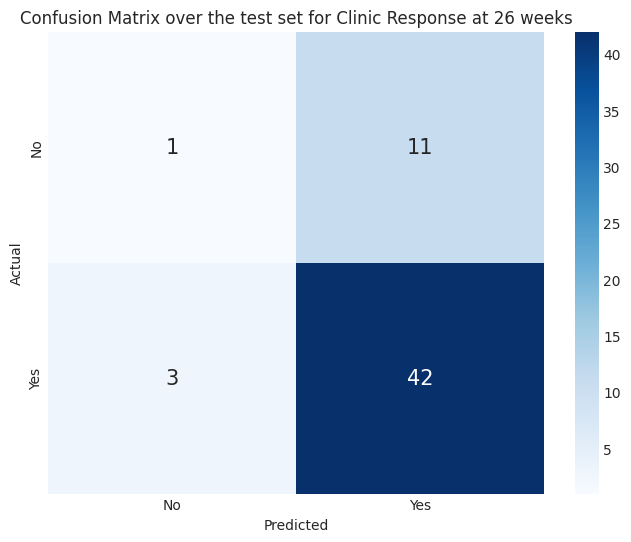

In [163]:
# Set the random seed for reproducibility
seed = 42

# Split the data into training and testing sets
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.25, random_state=seed, stratify=y1)

# Perform the one-hot encoding
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Rename the columns
X_train = X_train.rename(columns=remap_col_names)
X_test = X_test.rename(columns=remap_col_names)

# Define the parameters for the RandomizedSearchCV
params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [1, 2, 3, 4, 5]
}

# Initialize the XGBClassifier
xgb = XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='logloss')

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=1000, scoring='f1', n_jobs=-1, cv=5, verbose=1, random_state=seed)

# Fit the RandomizedSearchCV
print('\nFitting the RandomizedSearchCV')
random_search.fit(X_train, y1_train)

# Get the best parameters
best_params = random_search.best_params_
print('The best parameters are:')
print(best_params)
# Initialize the XGBClassifier with the best parameters
best_xgb_1 = XGBClassifier(**best_params, random_state=seed, use_label_encoder=False, eval_metric='logloss')

# Fit the model
best_xgb_1.fit(X_train, y1_train)

# Predict the target variable
y1_pred = best_xgb_1.predict(X_test)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y1_test, y1_pred)

# Calculate the f1 score, precision, and recall
f1 = f1_score(y1_test, y1_pred)
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])

# Print the f1 score, precision, and recall
print('\nF1 Score:', np.round(f1, 4))
print('Precision:', np.round(precision, 4))
print('Recall:', np.round(recall, 4))

# Generate the classification report
print('\nClassification Report over the test set for res_clin_26:')
print(classification_report(y1_test, y1_pred))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'], annot_kws={"fontsize":15})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix over the test set for Clinic Response at 26 weeks')
plt.show()

In [164]:
# If the model json already exists, ask for remove or stop the process
if os.path.exists('./output/models/xgb_res_clin_26.json'):
    print("The file xgb_res_clin_26.json already exists.")
    print("Do you want to remove it?")
    remove = input("Type 'yes' to remove the file or 'no' to stop the process: ")
    if remove == 'yes':
        os.remove('./output/models/xgb_res_clin_26.json')
    else:
        print("The process was stopped.")
        exit()
else:
    os.mkdir('./output/models')

# Let's save the trained model
best_xgb_1.save_model('./output/models/xgb_res_clin_26.json')

# If the follow file exist ask for remove or stop the process
if os.path.exists('./output/models/xgb_res_clin_26.txt'):
    print("The file xgb_res_clin_26.txt already exists.")
    print("Do you want to remove it?")
    remove = input("Type 'yes' to remove the file or 'no' to stop the process: ")
    if remove == 'yes':
        os.remove('./output/models/xgb_res_clin_26.txt')
    else:
        print("The process was stopped.")
        exit()

# Save the classification report and the confusion matrix in the same file txt
with open('./output/models/xgb_res_clin_26.txt', 'w') as file:
    file.write('F1 Score: ' + str(np.round(f1, 4)) + '\n')
    file.write('Precision: ' + str(np.round(precision, 4)) + '\n')
    file.write('Recall: ' + str(np.round(recall, 4)) + '\n\n')
    file.write('Classification Report:\n')
    file.write(classification_report(y1_test, y1_pred))
    file.write('\n\nConfusion Matrix:\n')
    file.write(str(conf_matrix))

The file xgb_res_clin_26.json already exists.
Do you want to remove it?
The file xgb_res_clin_26.txt already exists.
Do you want to remove it?


Let's explain the model using the beeswarm plot.

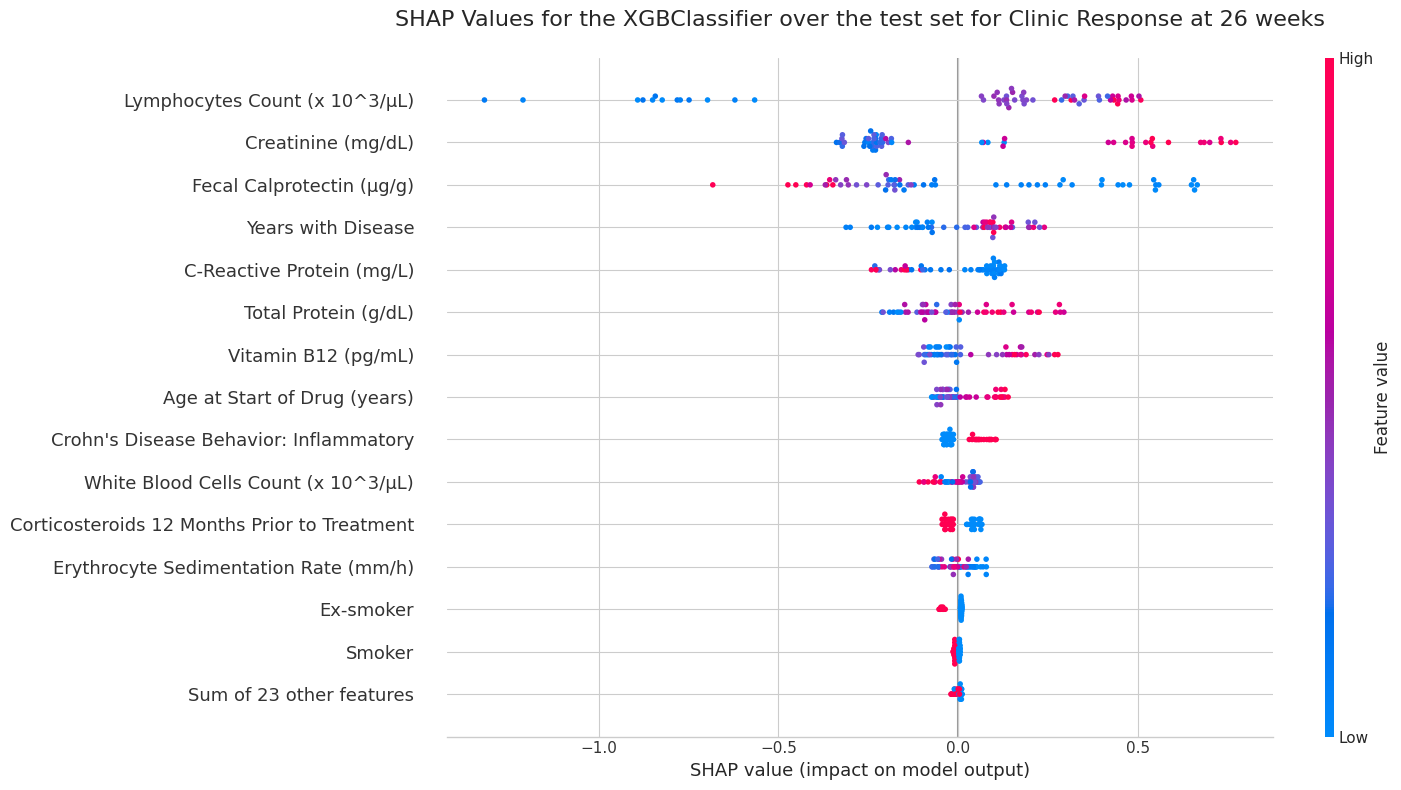

In [165]:
explainer = shap.Explainer(best_xgb_1)
shap_values = explainer(X_test)

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax = shap.plots.beeswarm(shap_values, max_display=15, plot_size=(15, 8), show=False)

# Add a fig title
plt.title('SHAP Values for the XGBClassifier over the test set for Clinic Response at 26 weeks\n', fontsize=16)
plt.tight_layout()
# Save the figure
plt.savefig('./output/models/shap_values_xgb_res_clin_26.png')

# Plot the ax
plt.show()

A stratified fairness analysis is performed.

In [166]:
sex_test = X_test['Sex (Male)'].map({False: 'Female', True:'Male'})

# Perform subgroup analysis by sex
sex_analysis = MetricFrame(metrics=f1_score, y_true=y1_test,
                           y_pred=y1_pred, sensitive_features=sex_test)
# Print the results
print("Sex Analysis:")
print(sex_analysis.by_group)

# Create a variable than encodes the age groups based on the ranges defined in ages_subgroups
group_ages_test = pd.cut(X_test['Age at Start of Drug (years)'], bins=[9, 19, 24, 64, float('inf')],
                       labels=['Adolescence', 'Youth', 'Adulthood', 'Old age'])
# Check the ranges
age_analysis= MetricFrame(metrics=f1_score, y_true=y1_test,
                          y_pred=y1_pred, sensitive_features=group_ages_test)

# Print the results
print("\nAge Analysis:")
print(age_analysis.by_group)

Sex Analysis:
Sex (Male)
Female    0.833333
Male      0.880000
Name: f1_score, dtype: float64

Age Analysis:
Age at Start of Drug (years)
Adolescence    1.000000
Adulthood      0.860759
Old age        0.727273
Youth          1.000000
Name: f1_score, dtype: float64


In [167]:
def fairness_analysis(sex_analysis, age_analysis, model_name):
        """
        This function generates a fairness analysis plot based
        on the results of the MetricFrame analysis by sex and age group.
        """
        
        # Configure the style and the plots
        plt.style.use('seaborn-whitegrid')
        gs = gridspec.GridSpec(1, 2, width_ratios=[2, 5])
        fig = plt.figure(figsize=(12,4.5))

        # Plot sex fairness analysis F1
        ax1 = plt.subplot(gs[0])
        sex_labels = sex_analysis.by_group.index.to_list()
        sex_labels.insert(0, 'Overall')
        sex_values = sex_analysis.by_group.values.tolist()
        sex_values.insert(0, sex_analysis.overall)
        
        bin_w1 = 0.6
        ax1.bar(sex_labels,
                sex_values,
                width=bin_w1,
                color=['#929292','#FF8431','#00C399'])
        ax1.axhline(sex_values[0], color='#929292', linestyle='--', linewidth=1)
        for i, value in enumerate(sex_values):
                ax1.text(i, value, round(value, 2), ha='center', va='bottom', fontsize=8)    

        ax1.set_ylim([0, 1])
        ax1.grid(axis='x')
        ax1.set_title('Analysis by Sex group', fontsize=10)
        ax1.set_ylabel('F1 score (test)')

        
        # Plot age fairness analysis F1
        ax2 = plt.subplot(gs[1])

        order_age = ['Adolescence', 'Youth', 'Adulthood', 'Old age']
        order_age_serie = age_analysis.by_group.reindex(order_age)
        print(order_age_serie)
        age_labels = order_age_serie.index.to_list()
        age_labels.insert(0, 'Overall')
        age_values = order_age_serie.values.tolist()
        age_values.insert(0, age_analysis.overall)
        bin_w2 = 0.4

        ax2.bar(age_labels,
                age_values,
                width=bin_w2,
                color=['#F939AA','#E843FA','#AB45F7','#7045F7','#343FC0'])
        ax2.axhline(age_values[0], color='#929292', linestyle='--', linewidth=1)
        for i, value in enumerate(age_values):
                if value < 0.95:
                    ax2.text(i, value, round(value, 2), ha='center', va='bottom', fontsize=8) 
                else:
                    ax2.text(i, value-0.015, round(value, 2), ha='center', va='top', fontsize=8, color='white')

        ax2.set_ylim([0, 1])
        ax2.grid(axis='x')
        ax2.set_title('Analysis by Age group', fontsize=10)
        ax2.set_ylabel('F1 score (test)')

        # Add title and plot it
        fig.suptitle(f'Fairness analysis for {model_name}', fontsize=12)
        plt.subplots_adjust(wspace=0.3)
        plt.show()

        # Save the figure
        output_dir = './output/models/fairness'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

                
        fig.savefig(f'{output_dir}/Analysis_{model_name}.png')

Age at Start of Drug (years)
Adolescence    1.000000
Youth          1.000000
Adulthood      0.860759
Old age        0.727273
Name: f1_score, dtype: float64


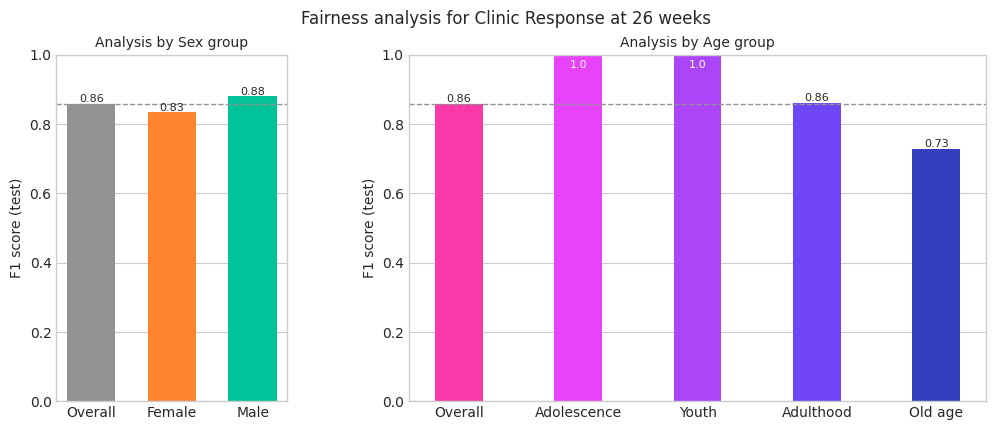

In [168]:
fairness_analysis(sex_analysis, age_analysis, 'Clinic Response at 26 weeks')

In [169]:
def plt_n_traintest_analysis(X_train, X_test, model_name):
        """
        This function generates a plot with the count of
        sex and age group in the training and test sets.
        """

        # Configure the style and the plots
        plt.style.use('seaborn-whitegrid')
        gs = gridspec.GridSpec(1, 2, width_ratios=[2, 5])
        fig = plt.figure(figsize=(15,6))

        # Plot the sex N splitting performed
        ax1 = plt.subplot(gs[0])
        sex_train = X_train['Sex (Male)'].map({True: 'Male', False:'Female'})
        sex_test = X_test['Sex (Male)'].map({True: 'Male', False:'Female'})
        bin_w1 = 0.8
        
        x_value = [i*3 for i in range(len(sex_train.unique()))]
        ax1.bar(x_value,
                sex_train.value_counts(),
                width=bin_w1,
                color='#5EA9EB',
                label='Training data')
        x_value = [i + bin_w1 for i in x_value]
        ax1.bar(x_value,
                sex_test.value_counts(),
                width=bin_w1,
                color='#5EA9EB',
                alpha=0.6,
                label='Test data')
        
        ax1.grid(axis='x')
        ax1.set_title('Count by Sex', fontsize=10)
        ax1.set_ylabel('Frequency')
        x_value = [i - bin_w1/2 for i in x_value]
        ax1.set_xticks(x_value)
        ax1.set_xticklabels(sex_train.value_counts().index.to_list())
        ax1.set_ylim([0,max(sex_train.value_counts())*1.2])
        ax1.legend()
        
        for i, value in enumerate(sex_train.value_counts()):
                ax1.text(i*3, value, round(value, 2), ha='center', va='bottom', fontsize=8)
        for i, value in enumerate(sex_test.value_counts()):
                ax1.text(i*3 + bin_w1, value, round(value, 2), ha='center', va='bottom', fontsize=8)
        

        # Plot the age N splitting performed
        ax2 = plt.subplot(gs[1])

        # Reorder serie based on the index
        age_group_train = pd.cut(X_train['Age at Start of Drug (years)'], bins=[9, 19, 24, 64, float('inf')],
                               labels=['Adolescence', 'Youth', 'Adulthood', 'Old age'])
        age_group_test = pd.cut(X_test['Age at Start of Drug (years)'], bins=[9, 19, 24, 64, float('inf')],
                               labels=['Adolescence', 'Youth', 'Adulthood', 'Old age'])
        new_index_order = ['Adolescence', 'Youth', 'Adulthood', 'Old age']
        age_group_train_count = age_group_train.value_counts().reindex(new_index_order)
        age_group_test_count = age_group_test.value_counts().reindex(new_index_order)

        bin_w2 = 0.8

        x_value = [i*3 for i in range(len(age_group_train_count))]
        ax2.bar(x_value,
                age_group_train_count.values,
                width=bin_w2,
                color='#EB988F',
                label='Training data')
        x_value = [i + bin_w2 for i in x_value]
        ax2.bar(x_value,
                age_group_test_count.values,
                width=bin_w2,
                color='#EB988F',
                alpha=0.7,
                label='Test data')

        ax2.grid(axis='x')
        ax2.set_title('Count by Age group', fontsize=10)
        ax2.set_ylabel('Frequency')
        x_value = [i - bin_w2/2 for i in x_value]
        ax2.set_xticks(x_value)
        ax2.set_xticklabels(new_index_order)
        ax2.set_ylim([0,max(age_group_train.value_counts())*1.2])
        ax2.legend()

        for i, value in enumerate(age_group_train_count.values):
                ax2.text(i*3, value, round(value, 2), ha='center', va='bottom', fontsize=8) 
        for i, value in enumerate(age_group_test_count.values):
                ax2.text(i*3 + bin_w2, value, round(value, 2), ha='center', va='bottom', fontsize=8)


        plt.suptitle(f'Analysis of train-test split for {model_name}', fontsize=12)
        plt.subplots_adjust(wspace=0.2)
        plt.show()

        # Save the figure
        output_dir = './output/models/fairness'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        fig.savefig(f'{output_dir}/Split_Traintest_{model_name}.png')

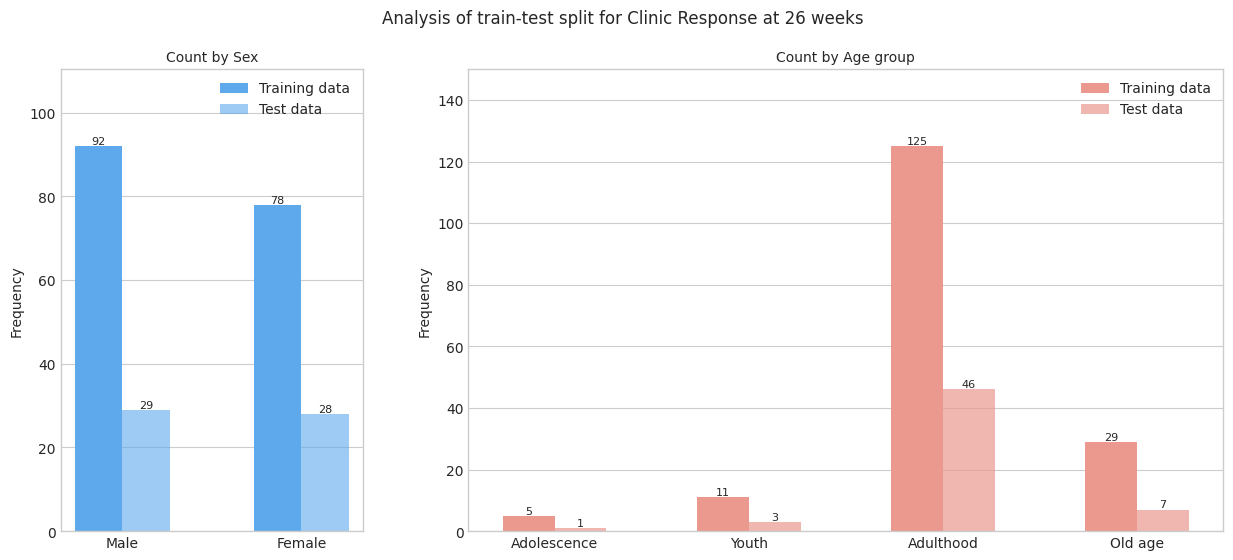

In [170]:
plt_n_traintest_analysis(X_train, X_test, 'Clinic Response at 26 weeks')

### 5.2.Res_clin_52 model

Let's train a model to predict the target variable `res_clin_52`. We will use XGBClassifier from XGBoost performing a RandomizedSearchCV to find the best hyperparameters.


Fitting the RandomizedSearchCV
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
The best parameters are:
{'subsample': 0.9, 'n_estimators': 100, 'min_child_weight': 4, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}

F1 Score: 0.8571
Precision: 0.8077
Recall: 0.913

Classification Report over the test set for res_clin_52:
              precision    recall  f1-score   support

           0       0.20      0.09      0.12        11
           1       0.81      0.91      0.86        46

    accuracy                           0.75        57
   macro avg       0.50      0.50      0.49        57
weighted avg       0.69      0.75      0.72        57



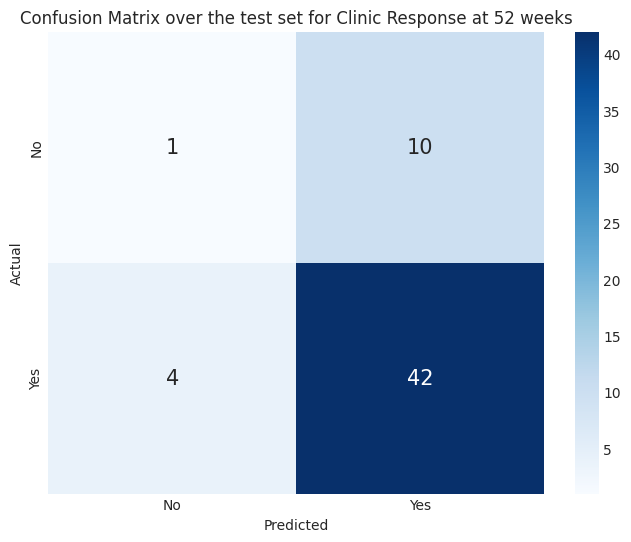

In [171]:
# Set the random seed for reproducibility
seed = 42

# Split the data into training and testing sets
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.25, random_state=seed, stratify=y2)

# Perform the one-hot encoding
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Rename the columns
X_train = X_train.rename(columns=remap_col_names)
X_test = X_test.rename(columns=remap_col_names)

# Define the parameters for the RandomizedSearchCV
params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [1, 2, 3, 4, 5]
}

# Initialize the XGBClassifier
xgb = XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='logloss')

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=1000, scoring='f1', n_jobs=-1, cv=5, verbose=1, random_state=seed)

# Fit the RandomizedSearchCV
print('\nFitting the RandomizedSearchCV')
random_search.fit(X_train, y2_train)

# Get the best parameters
best_params = random_search.best_params_
print('The best parameters are:')
print(best_params)
# Initialize the XGBClassifier with the best parameters
best_xgb_2 = XGBClassifier(**best_params, random_state=seed, use_label_encoder=False, eval_metric='logloss')

# Fit the model
best_xgb_2.fit(X_train, y2_train)

# Predict the target variable
y2_pred = best_xgb_2.predict(X_test)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y2_test, y2_pred)

# Calculate the f1 score, precision, and recall
f1 = f1_score(y2_test, y2_pred)
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])

# Print the f1 score, precision, and recall
print('\nF1 Score:', np.round(f1, 4))
print('Precision:', np.round(precision, 4))
print('Recall:', np.round(recall, 4))

# Generate the classification report
print('\nClassification Report over the test set for res_clin_52:')
print(classification_report(y2_test, y2_pred))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'], annot_kws={"fontsize":15})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix over the test set for Clinic Response at 52 weeks')
plt.show()

In [172]:
# If the model json already exists, ask for remove or stop the process
if os.path.exists('./output/models/xgb_res_clin_52.json'):
    print("The file xgb_res_clin_52.json already exists.")
    print("Do you want to remove it?")
    remove = input("Type 'yes' to remove the file or 'no' to stop the process: ")
    if remove == 'yes':
        os.remove('./output/models/xgb_res_clin_52.json')
    else:
        print("The process was stopped.")
        exit()

# Let's save the trained model
best_xgb_2.save_model('./output/models/xgb_res_clin_52.json')

# If the follow file exist ask for remove or stop the process
if os.path.exists('./output/models/xgb_res_clin_52.txt'):
    print("The file xgb_res_clin_52.txt already exists.")
    print("Do you want to remove it?")
    remove = input("Type 'yes' to remove the file or 'no' to stop the process: ")
    if remove == 'yes':
        os.remove('./output/models/xgb_res_clin_52.txt')
    else:
        print("The process was stopped.")
        exit()

# Save the classification report and the confusion matrix in the same file txt
with open('./output/models/xgb_res_clin_52.txt', 'w') as file:
    file.write('F1 Score: ' + str(np.round(f1, 4)) + '\n')
    file.write('Precision: ' + str(np.round(precision, 4)) + '\n')
    file.write('Recall: ' + str(np.round(recall, 4)) + '\n\n')
    file.write('Classification Report:\n')
    file.write(classification_report(y2_test, y2_pred))
    file.write('\n\nConfusion Matrix:\n')
    file.write(str(conf_matrix))

The file xgb_res_clin_52.json already exists.
Do you want to remove it?
The file xgb_res_clin_52.txt already exists.
Do you want to remove it?


Let's explain the model using the beeswarm plot.

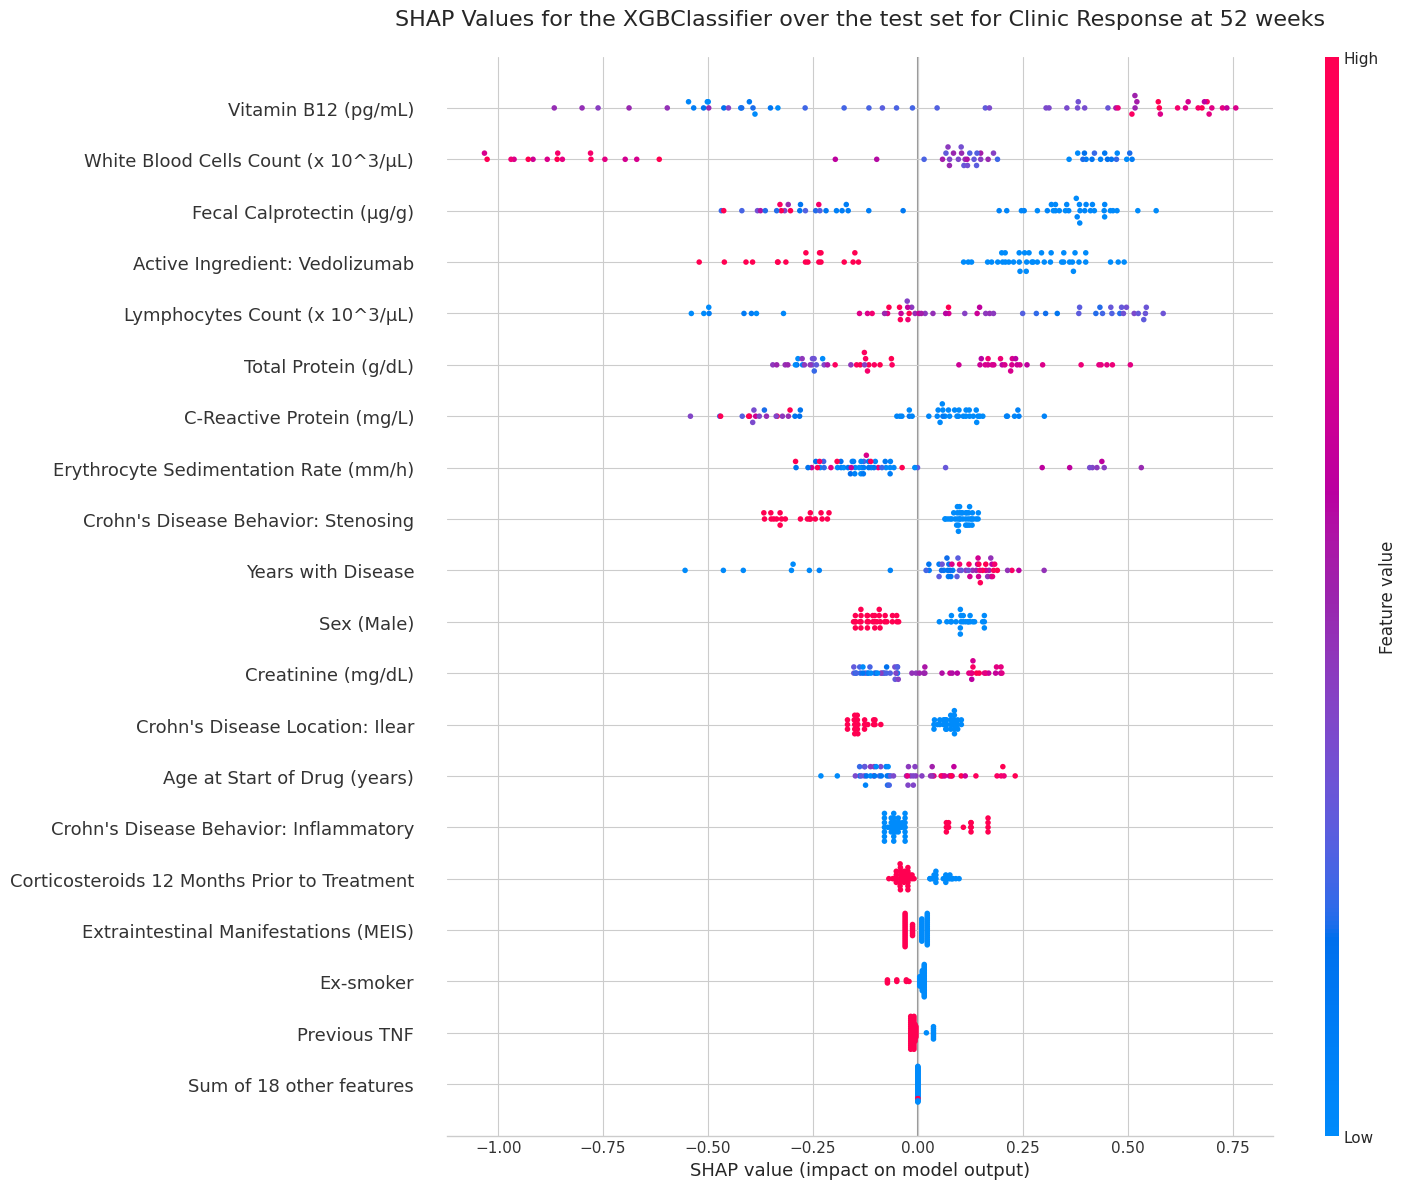

In [173]:
explainer = shap.Explainer(best_xgb_2)
shap_values = explainer(X_test)

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax = shap.plots.beeswarm(shap_values,  max_display=20, plot_size=(15, 12), show=False)

# Add a fig title
plt.title('SHAP Values for the XGBClassifier over the test set for Clinic Response at 52 weeks\n', fontsize=16)
plt.tight_layout()
# Save the figure
plt.savefig('./output/models/shap_values_xgb_res_clin_52.png')

# Plot the ax
plt.show()

A stratified fairness analysis is performed.

In [174]:
sex_test = X_test['Sex (Male)'].map({False: 'Female', True:'Male'})

# Perform subgroup analysis by sex
sex_analysis = MetricFrame(metrics=f1_score, y_true=y2_test,
                           y_pred=y2_pred, sensitive_features=sex_test)
# Print the results
print("Sex Analysis:")
print(sex_analysis.by_group)

# Create a variable than encodes the age groups based on the ranges defined in ages_subgroups
group_ages_test = pd.cut(X_test['Age at Start of Drug (years)'], bins=[9, 19, 24, 64, float('inf')],
                       labels=['Adolescence', 'Youth', 'Adulthood', 'Old age'])
# Check the ranges
age_analysis= MetricFrame(metrics=f1_score, y_true=y2_test,
                          y_pred=y2_pred, sensitive_features=group_ages_test)

# Print the results
print("\nAge Analysis:")
print(age_analysis.by_group)

Sex Analysis:
Sex (Male)
Female    0.857143
Male      0.857143
Name: f1_score, dtype: float64

Age Analysis:
Age at Start of Drug (years)
Adolescence    0.000000
Adulthood      0.849315
Old age        0.923077
Youth          0.909091
Name: f1_score, dtype: float64


Age at Start of Drug (years)
Adolescence    0.000000
Youth          0.909091
Adulthood      0.849315
Old age        0.923077
Name: f1_score, dtype: float64


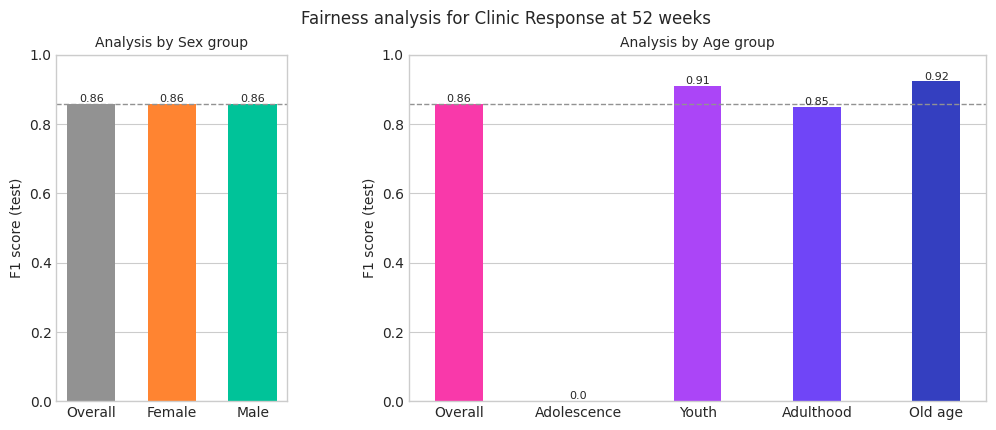

In [175]:
fairness_analysis(sex_analysis, age_analysis, 'Clinic Response at 52 weeks')

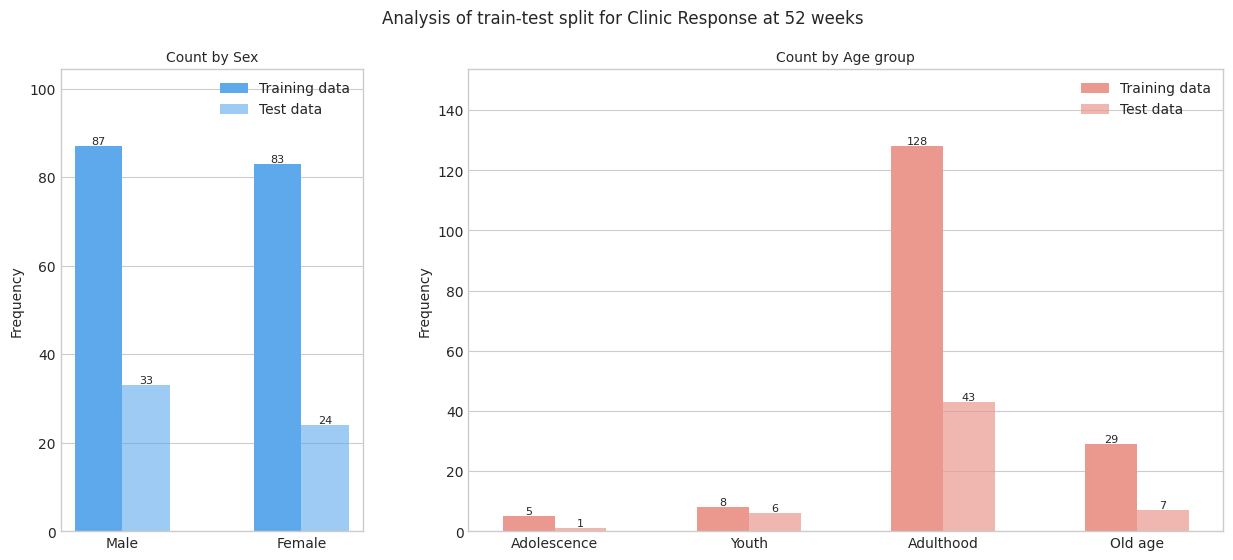

In [176]:
plt_n_traintest_analysis(X_train, X_test, 'Clinic Response at 52 weeks')

### 5.3.Rem_clin_52 model

Let's train a model to predict the target variable `rem_clin_52`. We will use XGBClassifier from XGBoost performing a RandomizedSearchCV to find the best hyperparameters.


Fitting the RandomizedSearchCV
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
The best parameters are:
{'subsample': 0.5, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.4, 'colsample_bytree': 0.5}

F1 Score: 0.6842
Precision: 0.5778
Recall: 0.8387

Classification Report over the test set for rem_clin_52:
              precision    recall  f1-score   support

           0       0.58      0.27      0.37        26
           1       0.58      0.84      0.68        31

    accuracy                           0.58        57
   macro avg       0.58      0.55      0.53        57
weighted avg       0.58      0.58      0.54        57



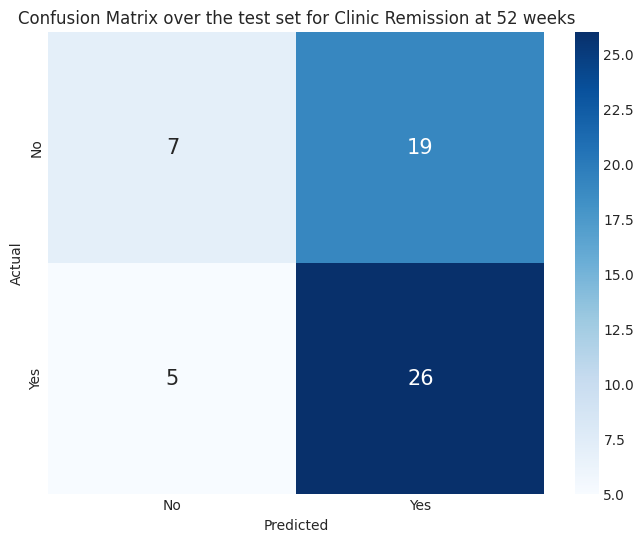

In [193]:
# Set the random seed for reproducibility
seed = 42

# Split the data into training and testing sets
X_train, X_test, y3_train, y3_test = train_test_split(X, y3, test_size=0.25, random_state=seed, stratify=y3)

# Perform the one-hot encoding
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Rename the columns
X_train = X_train.rename(columns=remap_col_names)
X_test = X_test.rename(columns=remap_col_names)

# Initialize the XGBClassifier
xgb = XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='logloss')

# Define the parameters for the RandomizedSearchCV
params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [1, 2, 3, 4, 5]
}

# Initialize the XGBClassifier
xgb = XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='logloss')

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=1000, scoring='f1', n_jobs=-1, cv=5, verbose=1, random_state=seed)

# Fit the RandomizedSearchCV
print('\nFitting the RandomizedSearchCV')
random_search.fit(X_train, y3_train)

# Get the best parameters
best_params = random_search.best_params_
print('The best parameters are:')
print(best_params)
# Initialize the XGBClassifier with the best parameters
best_xgb_3 = XGBClassifier(**best_params, random_state=seed, use_label_encoder=False, eval_metric='logloss')

# Fit the model
best_xgb_3.fit(X_train, y3_train)

# Predict the target variable
y3_pred = best_xgb_3.predict(X_test)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y3_test, y3_pred)

# Calculate the f1 score, precision, and recall
f1 = f1_score(y3_test, y3_pred)
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])

# Print the f1 score, precision, and recall
print('\nF1 Score:', np.round(f1, 4))
print('Precision:', np.round(precision, 4))
print('Recall:', np.round(recall, 4))

# Generate the classification report
print('\nClassification Report over the test set for rem_clin_52:')
print(classification_report(y3_test, y3_pred))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'], annot_kws={"fontsize":15})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix over the test set for Clinic Remission at 52 weeks')
plt.show()

In [178]:
# If the model json already exists, ask for remove or stop the process
if os.path.exists('./output/models/xgb_rem_clin_52.json'):
    print("The file xgb_rem_clin_52.json already exists.")
    print("Do you want to remove it?")
    remove = input("Type 'yes' to remove the file or 'no' to stop the process: ")
    if remove == 'yes':
        os.remove('./output/models/xgb_rem_clin_52.json')
    else:
        print("The process was stopped.")
        exit()

# Let's save the trained model
best_xgb_2.save_model('./output/models/xgb_rem_clin_52.json')

# If the follow file exist ask for remove or stop the process
if os.path.exists('./output/models/xgb_rem_clin_52.txt'):
    print("The file xgb_rem_clin_52.txt already exists.")
    print("Do you want to remove it?")
    remove = input("Type 'yes' to remove the file or 'no' to stop the process: ")
    if remove == 'yes':
        os.remove('./output/models/xgb_rem_clin_52.txt')
    else:
        print("The process was stopped.")
        exit()

# Save the classification report and the confusion matrix in the same file txt
with open('./output/models/xgb_rem_clin_52.txt', 'w') as file:
    file.write('F1 Score: ' + str(np.round(f1, 4)) + '\n')
    file.write('Precision: ' + str(np.round(precision, 4)) + '\n')
    file.write('Recall: ' + str(np.round(recall, 4)) + '\n\n')
    file.write('Classification Report:\n')
    file.write(classification_report(y3_test, y3_pred))
    file.write('\n\nConfusion Matrix:\n')
    file.write(str(conf_matrix))

The file xgb_rem_clin_52.json already exists.
Do you want to remove it?
The file xgb_rem_clin_52.txt already exists.
Do you want to remove it?


Let's explain the model using the beeswarm plot.

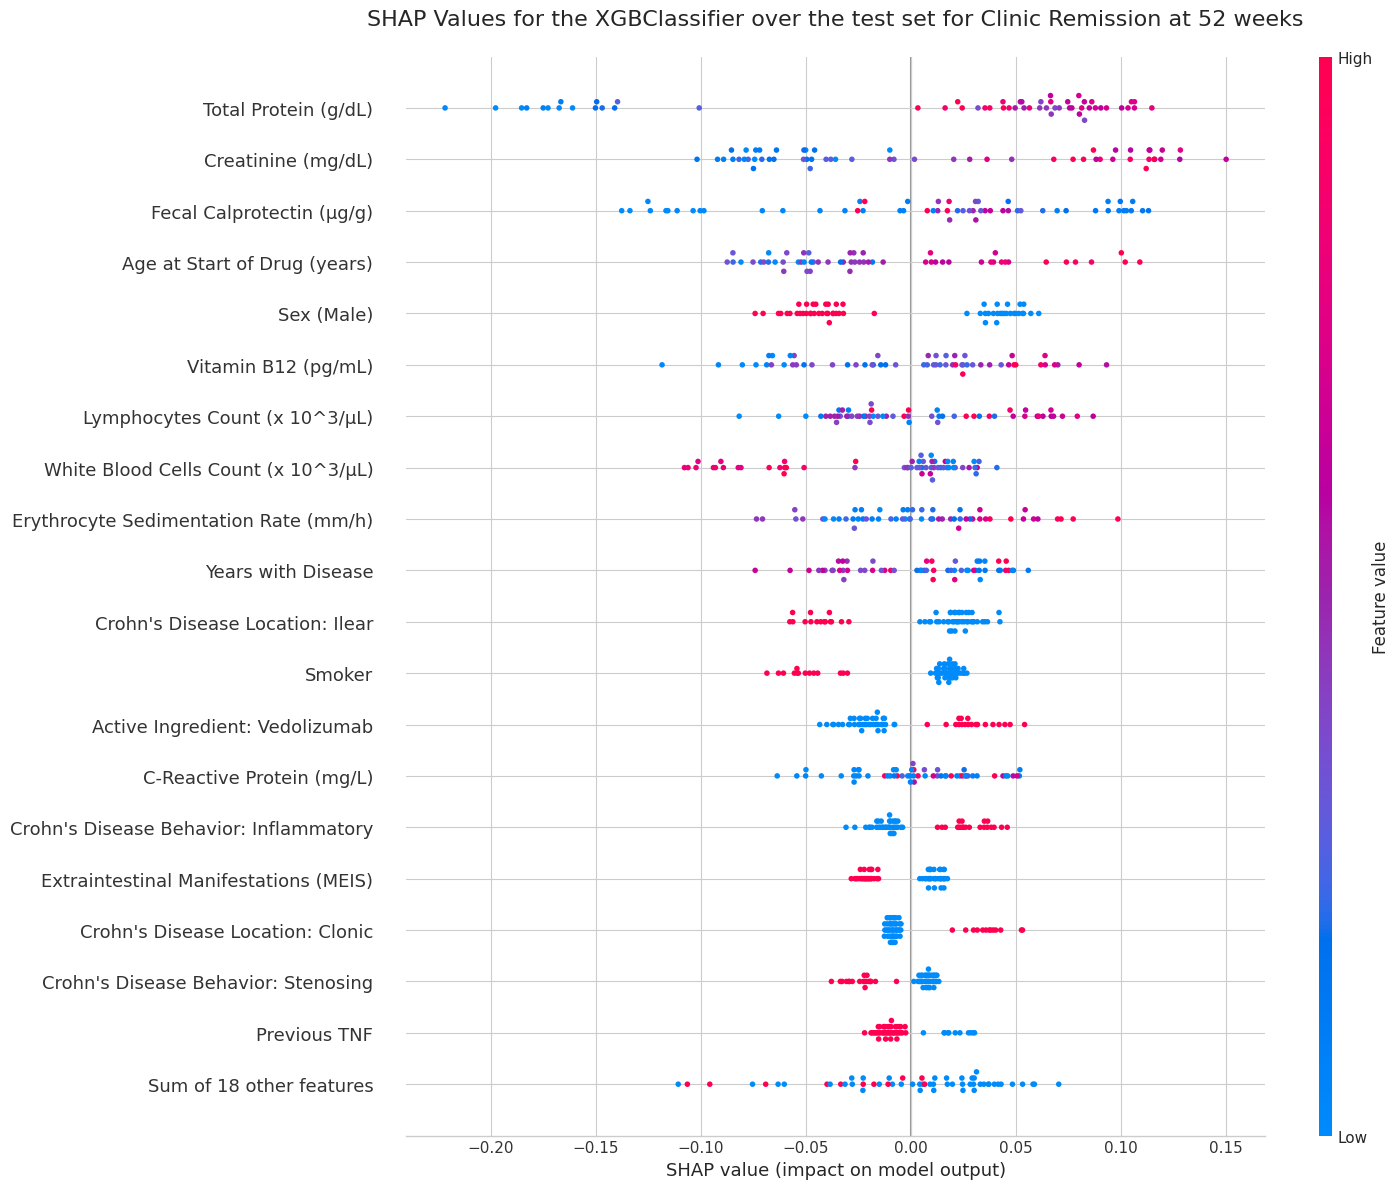

In [194]:
explainer = shap.Explainer(best_xgb_3)
shap_values = explainer(X_test)

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax = shap.plots.beeswarm(shap_values,  max_display=20, plot_size=(15, 12), show=False)

# Add a fig title
plt.title('SHAP Values for the XGBClassifier over the test set for Clinic Remission at 52 weeks\n', fontsize=16)
plt.tight_layout()
# Save the figure
plt.savefig('./output/models/shap_values_xgb_rem_clin_52.png')

# Plot the ax
plt.show()

In [180]:
sex_test = X_test['Sex (Male)'].map({False: 'Female', True:'Male'})

# Perform subgroup analysis by sex
sex_analysis = MetricFrame(metrics=f1_score, y_true=y3_test,
                           y_pred=y3_pred, sensitive_features=sex_test)
# Print the results
print("Sex Analysis:")
print(sex_analysis.by_group)

# Create a variable than encodes the age groups based on the ranges defined in ages_subgroups
group_ages_test = pd.cut(X_test['Age at Start of Drug (years)'], bins=[9, 19, 24, 64, float('inf')],
                       labels=['Adolescence', 'Youth', 'Adulthood', 'Old age'])
# Check the ranges
age_analysis= MetricFrame(metrics=f1_score, y_true=y3_test,
                          y_pred=y3_pred, sensitive_features=group_ages_test)

# Print the results
print("\nAge Analysis:")
print(age_analysis.by_group)

Sex Analysis:
Sex (Male)
Female    0.666667
Male      0.700000
Name: f1_score, dtype: float64

Age Analysis:
Age at Start of Drug (years)
Adolescence    0.500000
Adulthood      0.711864
Old age        0.666667
Youth          0.500000
Name: f1_score, dtype: float64


Age at Start of Drug (years)
Adolescence    0.500000
Youth          0.500000
Adulthood      0.711864
Old age        0.666667
Name: f1_score, dtype: float64


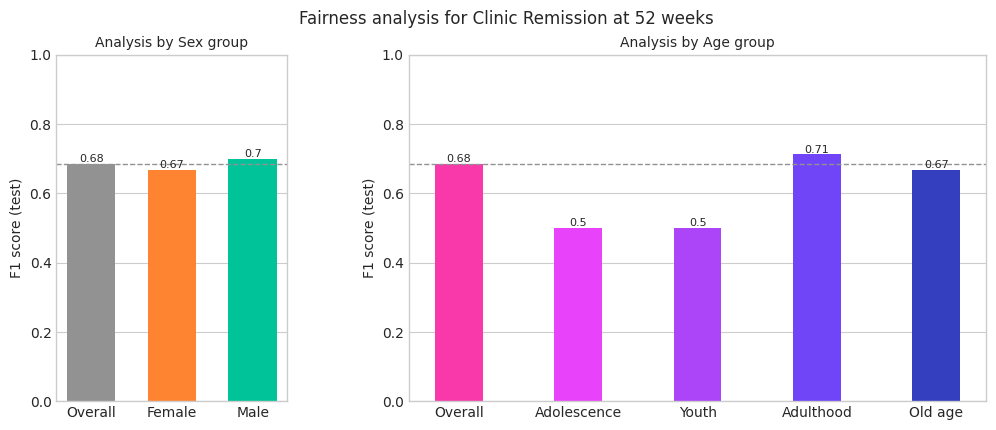

In [181]:
fairness_analysis(sex_analysis, age_analysis, 'Clinic Remission at 52 weeks')

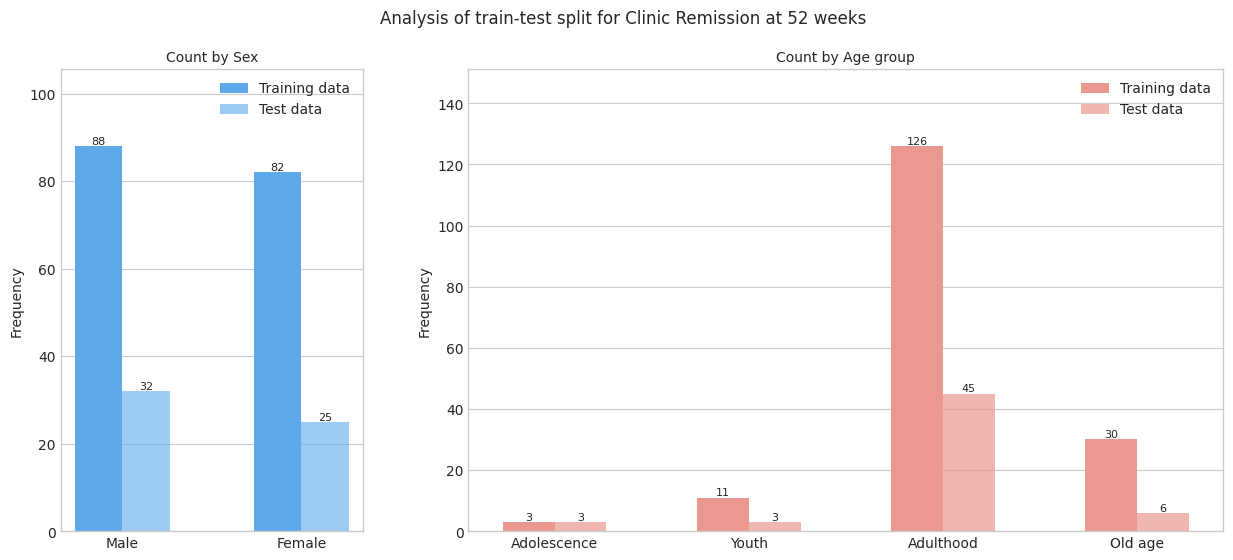

In [182]:
plt_n_traintest_analysis(X_train, X_test, 'Clinic Remission at 52 weeks')

# 6. Subgroups Analysis

## 6.1.Crohn's Disease + Vedolizumab

In [195]:
df_to_table_A = df_to_table[(df_to_table['ibd_type'] == 'Crohn\'s disease') & (df_to_table['active_ingredient'] == 'Vedolizumab')]
X_A = X[(df_to_table['ibd_type'] == 'Crohn\'s disease') & (df_to_table['active_ingredient'] == 'Vedolizumab')]
y2_A = y2[(df_to_table['ibd_type'] == 'Crohn\'s disease') & (df_to_table['active_ingredient'] == 'Vedolizumab')]
y3_A = y3[(df_to_table['ibd_type'] == 'Crohn\'s disease') & (df_to_table['active_ingredient'] == 'Vedolizumab')]

### 6.1.1. Response at week 52

Clinical response at 52 weeks table one

In [196]:
table1_crohnvedo_resclin52 = tableone_generator(df_to_table_A, 'clinical_response_52')
table1_crohnvedo_resclin52.to_excel('./output/table1_crohn+vedo_resclin52.xlsx')

display(table1_crohnvedo_resclin52)

Grouped by clinical_response_52                                                                       
                                                                                                     Missing              Overall                   No                  Yes P-Value
n                                                                                                                              45                   12                   33        
Active Ingredient, n (%)                              Vedolizumab                                          0           45 (100.0)           12 (100.0)           33 (100.0)   1.000
Sex, n (%)                                            Female                                               0            29 (64.4)            10 (83.3)            19 (57.6)   0.164
                                                      Male                                                              16 (35.6)             2 (16.7)            14 (42.4)        
Family IBD Degree, n (%)                              First degree relative                                1             7 (15.9)             2 (16.7)             5 (15.6)   0.825
                                                      No relative                                                       36 (81.8)            10 (83.3)            26 (81.2)        
                                                      Second degree relative                                              1 (2.3)                                   1 (3.1)        
Crohn's Disease Location, n (%)                       Ilear                                                0            21 (46.7)             9 (75.0)            12 (36.4)   0.056
                                                      Ileoclonic                                                        11 (24.4)             3 (25.0)             8 (24.2)        
                                                      Clonic                                                            12 (26.7)                                 12 (36.4)        
                                                      Ileal + Upper                                                       1 (2.2)                                   1 (3.0)        
Crohn's Disease Behavior, n (%)                       Fistulizing                                          0             8 (17.8)             2 (16.7)             6 (18.2)   0.335
                                                      Inflammatory                                                      22 (48.9)             4 (33.3)            18 (54.5)        
                                                      Stenosing                                                         15 (33.3)             6 (50.0)             9 (27.3)        
Ulcerative Colitis Extension, n (%)                   Another disease                                      0           45 (100.0)           12 (100.0)           33 (100.0)   1.000
IBD Type, n (%)                                       Crohn's disease                                      0           45 (100.0)           12 (100.0)           33 (100.0)   1.000
Previous TNF, n (%)                                   Yes                                                  0            26 (57.8)             6 (50.0)            20 (60.6)   0.767
                                                      No                                                                19 (42.2)             6 (50.0)            13 (39.4)        
Previous Ustekinumab, n (%)                           Yes                                                  0              1 (2.2)                                   1 (3.0)   1.000
                                                      No                                                                44 (97.8)           12 (100.0)            32 (97.0)        
Previous Vedolizumab, n (%)                           No                                                   0         


Fitting the RandomizedSearchCV
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
The best parameters are:
{'subsample': 0.9, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 0.8}

F1 Score: 0.8571
Precision: 0.75
Recall: 1.0

Classification Report over the test set for res_clin_52:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.75      1.00      0.86         9

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12



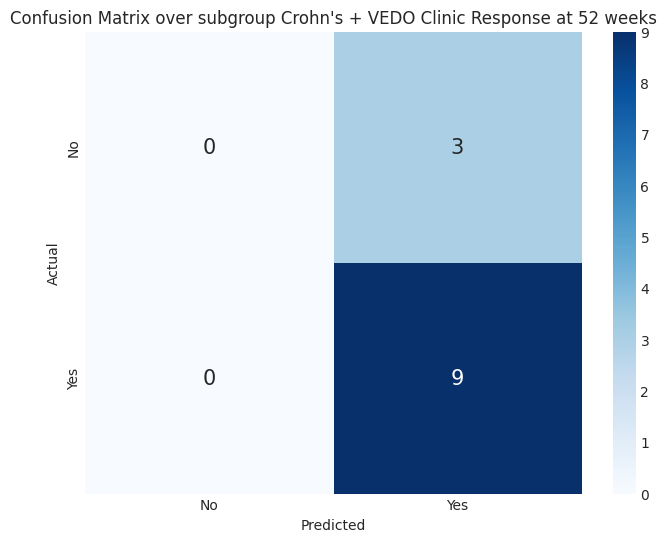

In [197]:
# Set the random seed for reproducibility
seed = 42

# Split the data into training and testing sets
X_train_A, X_test_A, y2_train_A, y2_test_A = train_test_split(X_A, y2_A, test_size=0.25, random_state=seed, stratify=y2_A)

# Perform the one-hot encoding
X_train_A = pd.get_dummies(X_train_A, drop_first=True)
X_test_A = pd.get_dummies(X_test_A, drop_first=True)

# Rename the columns
X_train_A = X_train_A.rename(columns=remap_col_names)
X_test_A = X_test_A.rename(columns=remap_col_names)

# Define the parameters for the RandomizedSearchCV
params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [1, 2, 3, 4, 5]
}

# Initialize the XGBClassifier
xgb = XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='logloss')

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=1000, scoring='f1', n_jobs=-1, cv=5, verbose=1, random_state=seed)

# Fit the RandomizedSearchCV
print('\nFitting the RandomizedSearchCV')
random_search.fit(X_train_A, y2_train_A)

# Get the best parameters
best_params = random_search.best_params_
print('The best parameters are:')
print(best_params)
# Initialize the XGBClassifier with the best parameters
best_xgb_2 = XGBClassifier(**best_params, random_state=seed, use_label_encoder=False, eval_metric='logloss')

# Fit the model
best_xgb_2.fit(X_train_A, y2_train_A)

# Predict the target variable
y2_pred_A = best_xgb_2.predict(X_test_A)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y2_test_A, y2_pred_A)

# Calculate the f1 score, precision, and recall
f1 = f1_score(y2_test_A, y2_pred_A)
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])

# Print the f1 score, precision, and recall
print('\nF1 Score:', np.round(f1, 4))
print('Precision:', np.round(precision, 4))
print('Recall:', np.round(recall, 4))

# Generate the classification report
print('\nClassification Report over the test set for res_clin_52:')
print(classification_report(y2_test_A, y2_pred_A))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'], annot_kws={"fontsize":15})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix over subgroup Crohn\'s + VEDO Clinic Response at 52 weeks')
plt.show()

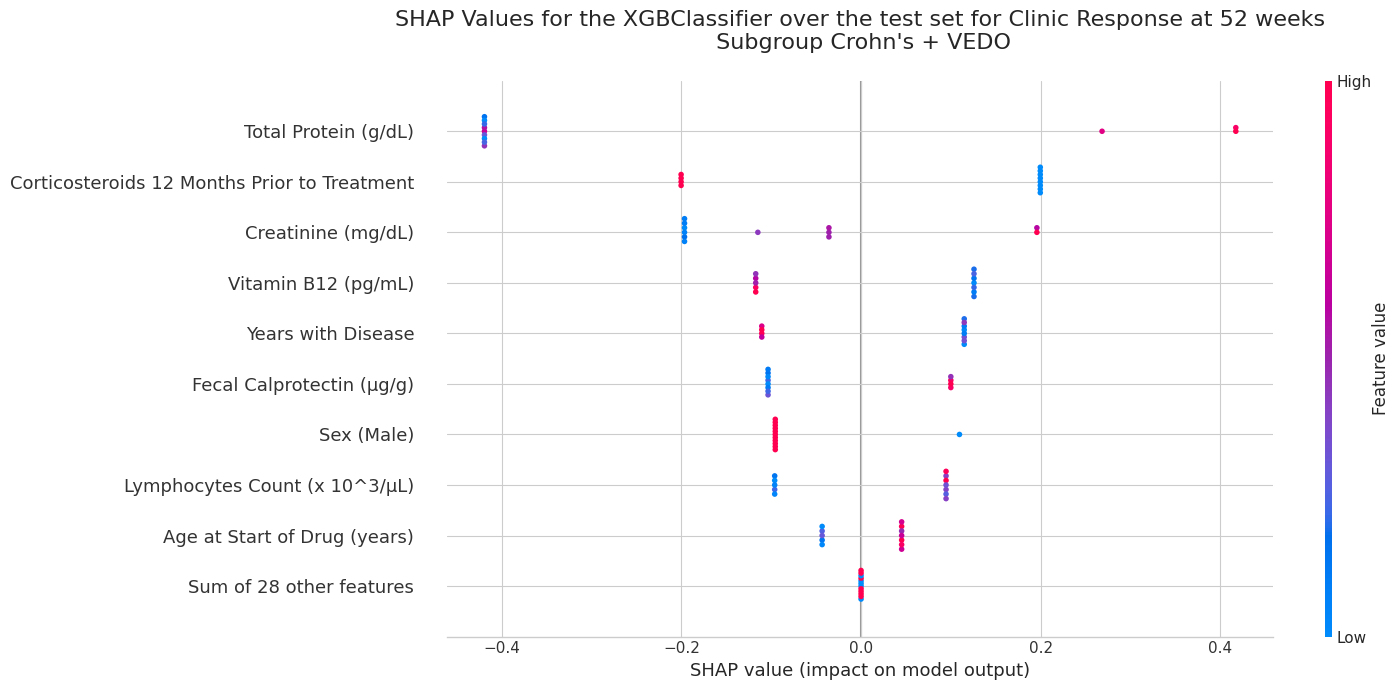

In [202]:
explainer = shap.Explainer(best_xgb_2)
shap_values = explainer(X_test_A)

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax = shap.plots.beeswarm(shap_values,  max_display=10, plot_size=(15, 7), show=False)

# Add a fig title
plt.title('SHAP Values for the XGBClassifier over the test set for Clinic Response at 52 weeks\n Subgroup Crohn\'s + VEDO\n', fontsize=16)
plt.tight_layout()
# Save the figure
plt.savefig('./output/models/shap_values_xgb_res_clin_52_subgroup61.png')

# Plot the ax
plt.show()

### 6.1.2. Remisison at week 52

Clinical remission at 52 weeks table one

In [203]:
table1_crohnvedo_remclin52 = tableone_generator(df_to_table_A, 'clinical_remission_52')
table1_crohnvedo_remclin52.to_excel('./output/table1_crohn+vedo_remclin52.xlsx')

display(table1_crohnvedo_remclin52)

Grouped by clinical_remission_52                                                                       
                                                                                                      Missing              Overall                   No                  Yes P-Value
n                                                                                                                               45                   20                   25        
Active Ingredient, n (%)                              Vedolizumab                                           0           45 (100.0)           20 (100.0)           25 (100.0)   1.000
Sex, n (%)                                            Female                                                0            29 (64.4)            15 (75.0)            14 (56.0)   0.313
                                                      Male                                                               16 (35.6)             5 (25.0)            11 (44.0)        
Family IBD Degree, n (%)                              First degree relative                                 1             7 (15.9)             2 (10.5)             5 (20.0)   0.378
                                                      No relative                                                        36 (81.8)            16 (84.2)            20 (80.0)        
                                                      Second degree relative                                               1 (2.3)              1 (5.3)                             
Crohn's Disease Location, n (%)                       Clonic                                                0            12 (26.7)             3 (15.0)             9 (36.0)   0.072
                                                      Ileal + Upper                                                        1 (2.2)              1 (5.0)                             
                                                      Ilear                                                              21 (46.7)            13 (65.0)             8 (32.0)        
                                                      Ileoclonic                                                         11 (24.4)             3 (15.0)             8 (32.0)        
Crohn's Disease Behavior, n (%)                       Fistulizing                                           0             8 (17.8)             5 (25.0)             3 (12.0)   0.076
                                                      Inflammatory                                                       22 (48.9)             6 (30.0)            16 (64.0)        
                                                      Stenosing                                                          15 (33.3)             9 (45.0)             6 (24.0)        
Ulcerative Colitis Extension, n (%)                   Another disease                                       0           45 (100.0)           20 (100.0)           25 (100.0)   1.000
IBD Type, n (%)                                       Crohn's disease                                       0           45 (100.0)           20 (100.0)           25 (100.0)   1.000
Previous TNF, n (%)                                   Yes                                                   0            26 (57.8)            11 (55.0)            15 (60.0)   0.973
                                                      No                                                                 19 (42.2)             9 (45.0)            10 (40.0)        
Previous Ustekinumab, n (%)                           Yes                                                   0              1 (2.2)              1 (5.0)                        0.444
                                                      No                                                                 44 (97.8)            19 (95.0)           25 (100.0)        
Previous Vedolizumab, n (%)                           No                                       


Fitting the RandomizedSearchCV
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
The best parameters are:
{'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 2, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 0.4, 'colsample_bytree': 0.6}

F1 Score: 0.6667
Precision: 0.625
Recall: 0.7143

Classification Report over the test set for res_clin_52:
              precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.62      0.71      0.67         7

    accuracy                           0.58        12
   macro avg       0.56      0.56      0.56        12
weighted avg       0.57      0.58      0.57        12



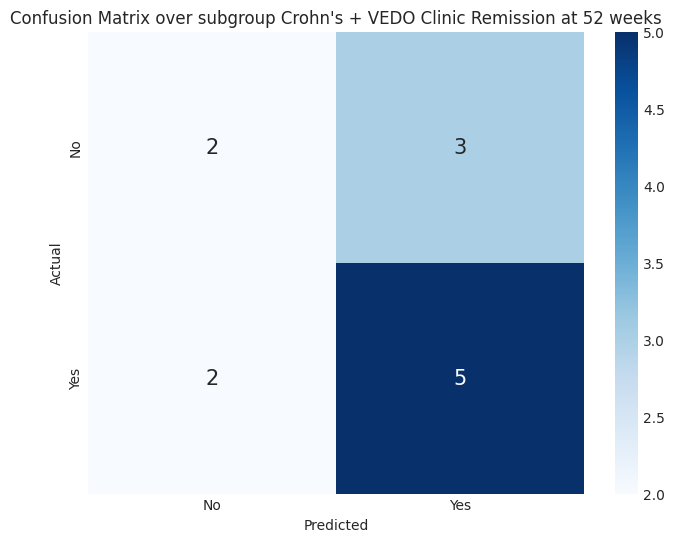

In [204]:
# Set the random seed for reproducibility
seed = 42

# Split the data into training and testing sets
X_train_A, X_test_A, y3_train_A, y3_test_A = train_test_split(X_A, y3_A, test_size=0.25, random_state=seed, stratify=y3_A)

# Perform the one-hot encoding
X_train_A = pd.get_dummies(X_train_A, drop_first=True)
X_test_A = pd.get_dummies(X_test_A, drop_first=True)

# Rename the columns
X_train_A = X_train_A.rename(columns=remap_col_names)
X_test_A = X_test_A.rename(columns=remap_col_names)

# Define the parameters for the RandomizedSearchCV
params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [1, 2, 3, 4, 5]
}

# Initialize the XGBClassifier
xgb = XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='logloss')

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=1000, scoring='f1', n_jobs=-1, cv=5, verbose=1, random_state=seed)

# Fit the RandomizedSearchCV
print('\nFitting the RandomizedSearchCV')
random_search.fit(X_train_A, y3_train_A)

# Get the best parameters
best_params = random_search.best_params_
print('The best parameters are:')
print(best_params)
# Initialize the XGBClassifier with the best parameters
best_xgb_2 = XGBClassifier(**best_params, random_state=seed, use_label_encoder=False, eval_metric='logloss')

# Fit the model
best_xgb_2.fit(X_train_A, y3_train_A)

# Predict the target variable
y3_pred_A = best_xgb_2.predict(X_test_A)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y3_test_A, y3_pred_A)

# Calculate the f1 score, precision, and recall
f1 = f1_score(y3_test_A, y3_pred_A)
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])

# Print the f1 score, precision, and recall
print('\nF1 Score:', np.round(f1, 4))
print('Precision:', np.round(precision, 4))
print('Recall:', np.round(recall, 4))

# Generate the classification report
print('\nClassification Report over the test set for res_clin_52:')
print(classification_report(y3_test_A, y3_pred_A))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'], annot_kws={"fontsize":15})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix over subgroup Crohn\'s + VEDO Clinic Remission at 52 weeks')
plt.show()

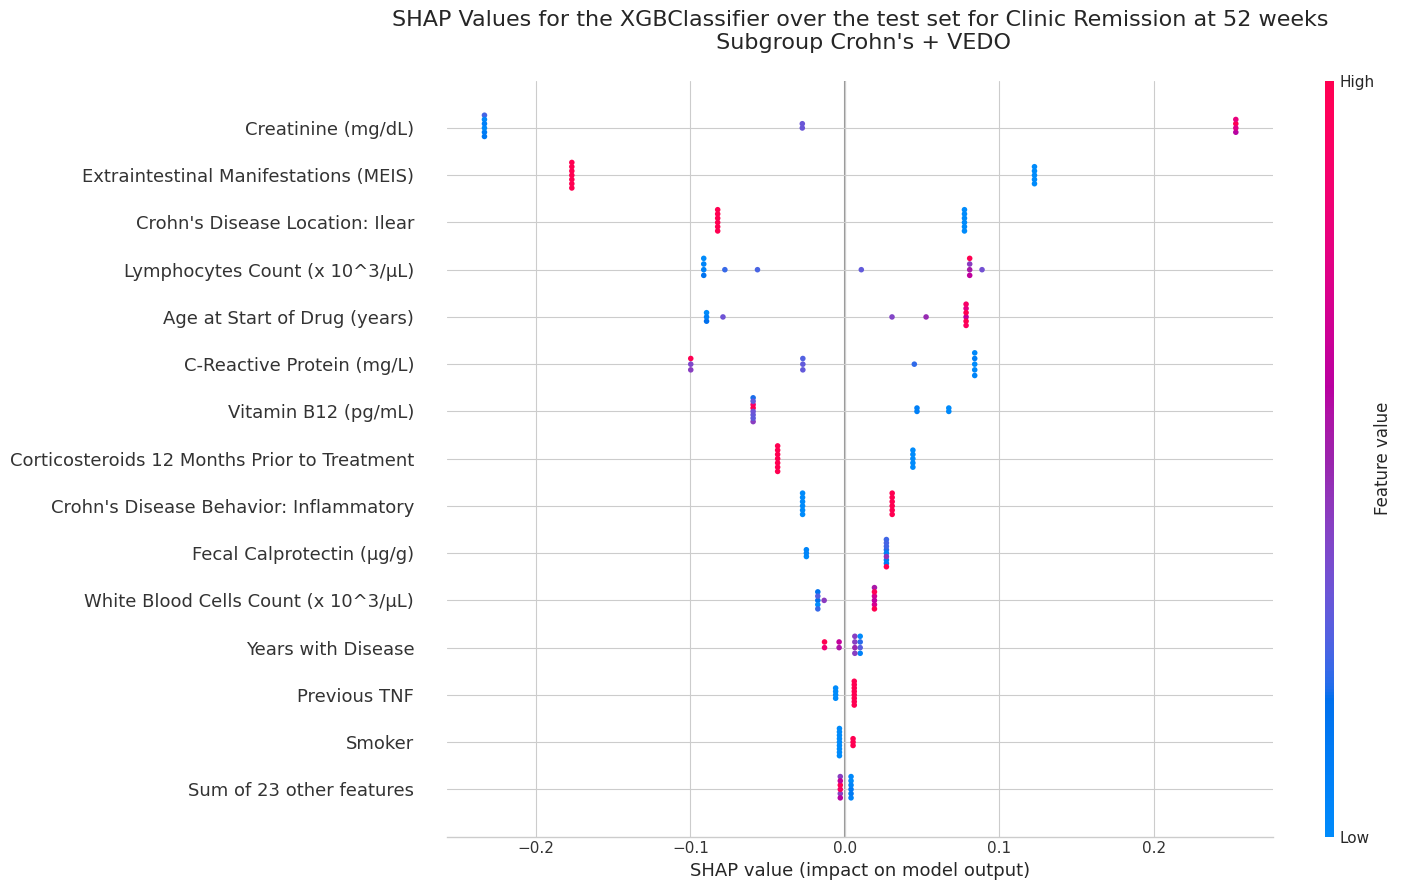

In [209]:
explainer = shap.Explainer(best_xgb_2)
shap_values = explainer(X_test_A)

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax = shap.plots.beeswarm(shap_values,  max_display=15, plot_size=(15, 9), show=False)

# Add a fig title
plt.title('SHAP Values for the XGBClassifier over the test set for Clinic Remission at 52 weeks\n Subgroup Crohn\'s + VEDO\n', fontsize=16)
plt.tight_layout()
# Save the figure
plt.savefig('./output/models/shap_values_xgb_rem_clin_52_subgroup61.png')

# Plot the ax
plt.show()

## 6.2 Ulcerative Colitis + Vedolizumab

In [210]:
df_to_table_B = df_to_table[(df_to_table['ibd_type'] == 'Ulcerative colitis') & (df_to_table['active_ingredient'] == 'Vedolizumab')]
X_B = X[(df_to_table['ibd_type'] == 'Ulcerative colitis') & (df_to_table['active_ingredient'] == 'Vedolizumab')]
y2_B = y2[(df_to_table['ibd_type'] == 'Ulcerative colitis') & (df_to_table['active_ingredient'] == 'Vedolizumab')]
y3_B = y3[(df_to_table['ibd_type'] == 'Ulcerative colitis') & (df_to_table['active_ingredient'] == 'Vedolizumab')]

### 6.2.1. Response at week 52

Clinical response at 52 weeks table one

In [211]:
table1_colitisvedo_resclin52 = tableone_generator(df_to_table_B, 'clinical_response_52')
table1_colitisvedo_resclin52.to_excel('./output/table1_colitis+vedo_resclin52.xlsx')

display(table1_colitisvedo_resclin52)

Grouped by clinical_response_52                                                                          
                                                                                                   Missing               Overall                    No                   Yes P-Value
n                                                                                                                             47                     9                    38        
Active Ingredient, n (%)                            Vedolizumab                                          0            47 (100.0)             9 (100.0)            38 (100.0)   1.000
Sex, n (%)                                          Female                                               0             19 (40.4)              3 (33.3)             16 (42.1)   0.720
                                                    Male                                                               28 (59.6)              6 (66.7)             22 (57.9)        
Family IBD Degree, n (%)                            First degree relative                                2               2 (4.4)              1 (11.1)               1 (2.8)   0.497
                                                    No relative                                                        42 (93.3)              8 (88.9)             34 (94.4)        
                                                    Second degree relative                                               1 (2.2)                                     1 (2.8)        
Crohn's Disease Location, n (%)                     Another disease                                      0            47 (100.0)             9 (100.0)            38 (100.0)   1.000
Crohn's Disease Behavior, n (%)                     Another disease                                      0            47 (100.0)             9 (100.0)            38 (100.0)   1.000
Ulcerative Colitis Extension, n (%)                 Left-sided colitis                                   0             20 (42.6)              1 (11.1)             19 (50.0)   0.102
                                                    Pancolitis                                                         21 (44.7)              6 (66.7)             15 (39.5)        
                                                    Proctitis                                                           6 (12.8)              2 (22.2)              4 (10.5)        
IBD Type, n (%)                                     Ulcerative colitis                                   0            47 (100.0)             9 (100.0)            38 (100.0)   1.000
Previous TNF, n (%)                                 Yes                                                  0             30 (63.8)              6 (66.7)             24 (63.2)   1.000
                                                    No                                                                 17 (36.2)              3 (33.3)             14 (36.8)        
Previous Ustekinumab, n (%)                         No                                                   0            47 (100.0)             9 (100.0)            38 (100.0)   1.000
Previous Vedolizumab, n (%)                         No                                                   0            47 (100.0)             9 (100.0)            38 (100.0)   1.000
Smoking Status, n (%)                               Non-smoker                                           0             34 (72.3)              6 (66.7)             28 (73.7)   0.338
                                                    Smoker                                                               4 (8.5)                                    4 (10.5)        
                                                    Ex-smoker                                                           9 (19.1)              3 (33.3)              6 (15.8)        
Extraintestinal Manifestations (MEIS), n (%)        Yes                                      


Fitting the RandomizedSearchCV
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
The best parameters are:
{'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 0.9}

F1 Score: 0.8571
Precision: 0.8182
Recall: 0.9

Classification Report over the test set for res_clin_52:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.82      0.90      0.86        10

    accuracy                           0.75        12
   macro avg       0.41      0.45      0.43        12
weighted avg       0.68      0.75      0.71        12



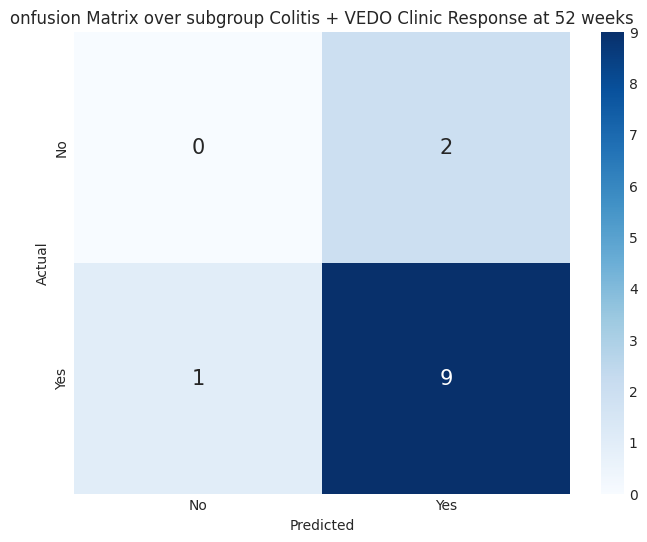

In [223]:
# Set the random seed for reproducibility
seed = 42

# Split the data into training and testing sets
X_train_B, X_test_B, y2_train_B, y2_test_B = train_test_split(X_B, y2_B, test_size=0.25, random_state=seed, stratify=y2_B)

# Perform the one-hot encoding
X_train_B = pd.get_dummies(X_train_B, drop_first=True)
X_test_B = pd.get_dummies(X_test_B, drop_first=True)

# Rename the columns
X_train_B = X_train_B.rename(columns=remap_col_names)
X_test_B = X_test_B.rename(columns=remap_col_names)

# Define the parameters for the RandomizedSearchCV
params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [1, 2, 3, 4, 5]
}

# Initialize the XGBClassifier
xgb = XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='logloss')

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=1000, scoring='f1', n_jobs=-1, cv=5, verbose=1, random_state=seed)

# Fit the RandomizedSearchCV
print('\nFitting the RandomizedSearchCV')
random_search.fit(X_train_B, y2_train_B)

# Get the best parameters
best_params = random_search.best_params_
print('The best parameters are:')
print(best_params)
# Initialize the XGBClassifier with the best parameters
best_xgb_2 = XGBClassifier(**best_params, random_state=seed, use_label_encoder=False, eval_metric='logloss')

# Fit the model
best_xgb_2.fit(X_train_B, y2_train_B)

# Predict the target variable
y2_pred_B = best_xgb_2.predict(X_test_B)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y2_test_B, y2_pred_B)

# Calculate the f1 score, precision, and recall
f1 = f1_score(y2_test_B, y2_pred_B)
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])

# Print the f1 score, precision, and recall
print('\nF1 Score:', np.round(f1, 4))
print('Precision:', np.round(precision, 4))
print('Recall:', np.round(recall, 4))

# Generate the classification report
print('\nClassification Report over the test set for res_clin_52:')
print(classification_report(y2_test_B, y2_pred_B))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'], annot_kws={"fontsize":15})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('onfusion Matrix over subgroup Colitis + VEDO Clinic Response at 52 weeks')
plt.show()

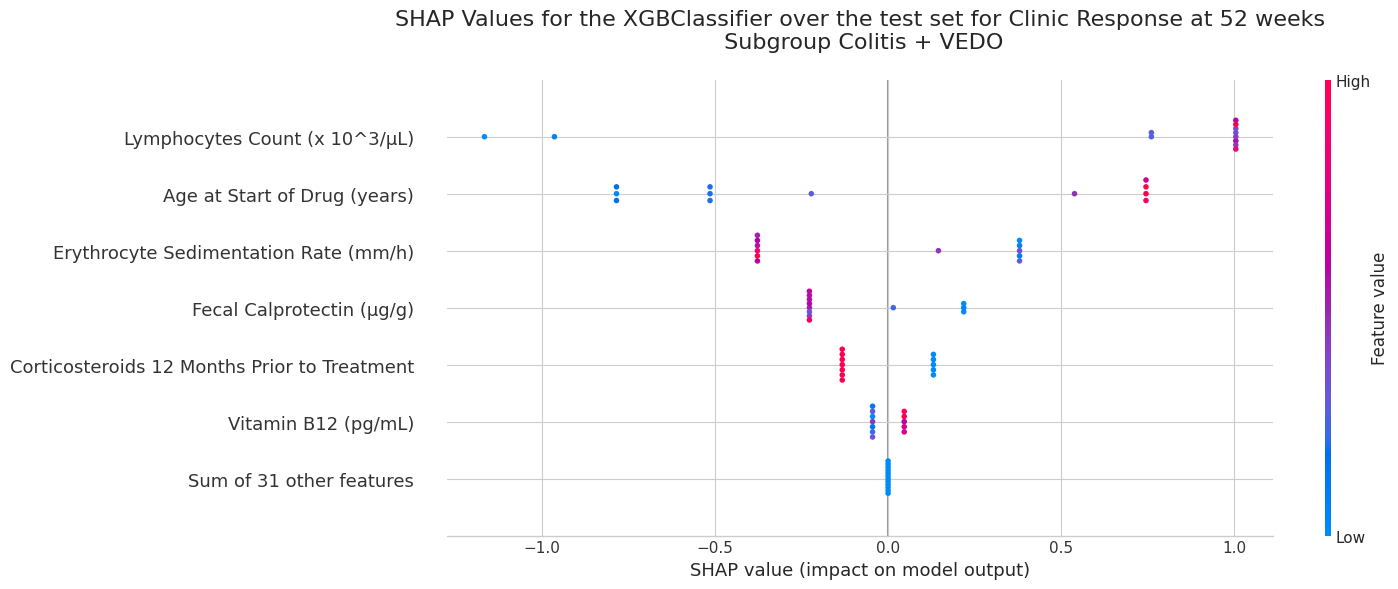

In [229]:
explainer = shap.Explainer(best_xgb_2)
shap_values = explainer(X_test_B)

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax = shap.plots.beeswarm(shap_values,  max_display=7, plot_size=(15, 6), show=False)

# Add a fig title
plt.title('SHAP Values for the XGBClassifier over the test set for Clinic Response at 52 weeks\n Subgroup Colitis + VEDO\n', fontsize=16)
plt.tight_layout()
# Save the figure
plt.savefig('./output/models/shap_values_xgb_res_clin_52_subgroup62.png')

# Plot the ax
plt.show()

### 6.2.2. Remission at week 52

Clinical remission at 52 weeks table one

In [230]:
table1_colitisvedo_remclin52 = tableone_generator(df_to_table_B, 'clinical_remission_52')
table1_colitisvedo_remclin52.to_excel('./output/table1_crohn+vedo_remclin52.xlsx')

display(table1_colitisvedo_remclin52)

Grouped by clinical_remission_52                                                                          
                                                                                                    Missing               Overall                   No                    Yes P-Value
n                                                                                                                              47                   18                     29        
Active Ingredient, n (%)                            Vedolizumab                                           0            47 (100.0)           18 (100.0)             29 (100.0)   1.000
Sex, n (%)                                          Female                                                0             19 (40.4)             8 (44.4)              11 (37.9)   0.891
                                                    Male                                                                28 (59.6)            10 (55.6)              18 (62.1)        
Family IBD Degree, n (%)                            First degree relative                                 2               2 (4.4)              1 (5.6)                1 (3.7)   0.439
                                                    No relative                                                         42 (93.3)            16 (88.9)              26 (96.3)        
                                                    Second degree relative                                                1 (2.2)              1 (5.6)                               
Crohn's Disease Location, n (%)                     Another disease                                       0            47 (100.0)           18 (100.0)             29 (100.0)   1.000
Crohn's Disease Behavior, n (%)                     Another disease                                       0            47 (100.0)           18 (100.0)             29 (100.0)   1.000
Ulcerative Colitis Extension, n (%)                 Left-sided colitis                                    0             20 (42.6)             6 (33.3)              14 (48.3)   0.492
                                                    Pancolitis                                                          21 (44.7)            10 (55.6)              11 (37.9)        
                                                    Proctitis                                                            6 (12.8)             2 (11.1)               4 (13.8)        
IBD Type, n (%)                                     Ulcerative colitis                                    0            47 (100.0)           18 (100.0)             29 (100.0)   1.000
Previous TNF, n (%)                                 Yes                                                   0             30 (63.8)            12 (66.7)              18 (62.1)   0.995
                                                    No                                                                  17 (36.2)             6 (33.3)              11 (37.9)        
Previous Ustekinumab, n (%)                         No                                                    0            47 (100.0)           18 (100.0)             29 (100.0)   1.000
Previous Vedolizumab, n (%)                         No                                                    0            47 (100.0)           18 (100.0)             29 (100.0)   1.000
Smoking Status, n (%)                               Non-smoker                                            0             34 (72.3)            14 (77.8)              20 (69.0)   0.774
                                                    Smoker                                                                4 (8.5)              1 (5.6)               3 (10.3)        
                                                    Ex-smoker                                                            9 (19.1)             3 (16.7)               6 (20.7)        
Extraintestinal Manifestations (MEIS), n (%)        Yes                


Fitting the RandomizedSearchCV
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
The best parameters are:
{'subsample': 0.5, 'n_estimators': 300, 'min_child_weight': 2, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.7}

F1 Score: 0.5714
Precision: 0.5714
Recall: 0.5714

Classification Report over the test set for res_clin_52:
              precision    recall  f1-score   support

           0       0.40      0.40      0.40         5
           1       0.57      0.57      0.57         7

    accuracy                           0.50        12
   macro avg       0.49      0.49      0.49        12
weighted avg       0.50      0.50      0.50        12



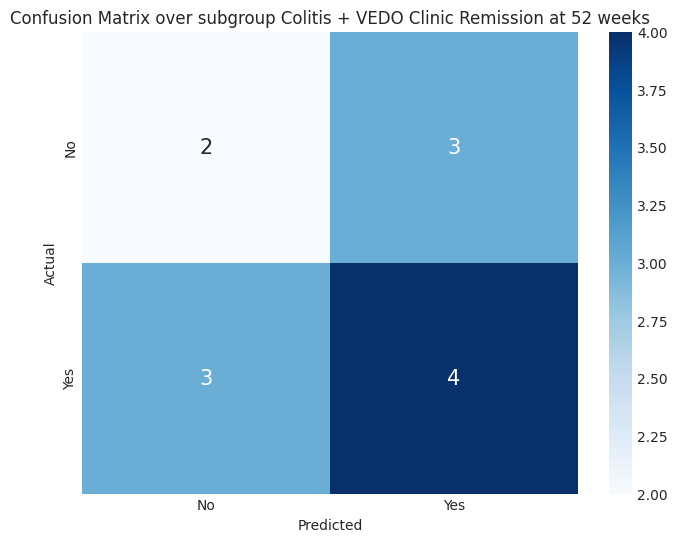

In [231]:
# Set the random seed for reproducibility
seed = 42

# Split the data into training and testing sets
X_train_B, X_test_B, y3_train_B, y3_test_B = train_test_split(X_B, y3_B, test_size=0.25, random_state=seed, stratify=y3_B)

# Perform the one-hot encoding
X_train_B = pd.get_dummies(X_train_B, drop_first=True)
X_test_B = pd.get_dummies(X_test_B, drop_first=True)

# Rename the columns
X_train_B = X_train_B.rename(columns=remap_col_names)
X_test_B = X_test_B.rename(columns=remap_col_names)

# Define the parameters for the RandomizedSearchCV
params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [1, 2, 3, 4, 5]
}

# Initialize the XGBClassifier
xgb = XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='logloss')

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=1000, scoring='f1', n_jobs=-1, cv=5, verbose=1, random_state=seed)

# Fit the RandomizedSearchCV
print('\nFitting the RandomizedSearchCV')
random_search.fit(X_train_B, y3_train_B)

# Get the best parameters
best_params = random_search.best_params_
print('The best parameters are:')
print(best_params)
# Initialize the XGBClassifier with the best parameters
best_xgb_2 = XGBClassifier(**best_params, random_state=seed, use_label_encoder=False, eval_metric='logloss')

# Fit the model
best_xgb_2.fit(X_train_B, y3_train_B)

# Predict the target variable
y3_pred_B = best_xgb_2.predict(X_test_B)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y3_test_B, y3_pred_B)

# Calculate the f1 score, precision, and recall
f1 = f1_score(y3_test_B, y3_pred_B)
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])

# Print the f1 score, precision, and recall
print('\nF1 Score:', np.round(f1, 4))
print('Precision:', np.round(precision, 4))
print('Recall:', np.round(recall, 4))

# Generate the classification report
print('\nClassification Report over the test set for res_clin_52:')
print(classification_report(y3_test_B, y3_pred_B))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'], annot_kws={"fontsize":15})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix over subgroup Colitis + VEDO Clinic Remission at 52 weeks')
plt.show()

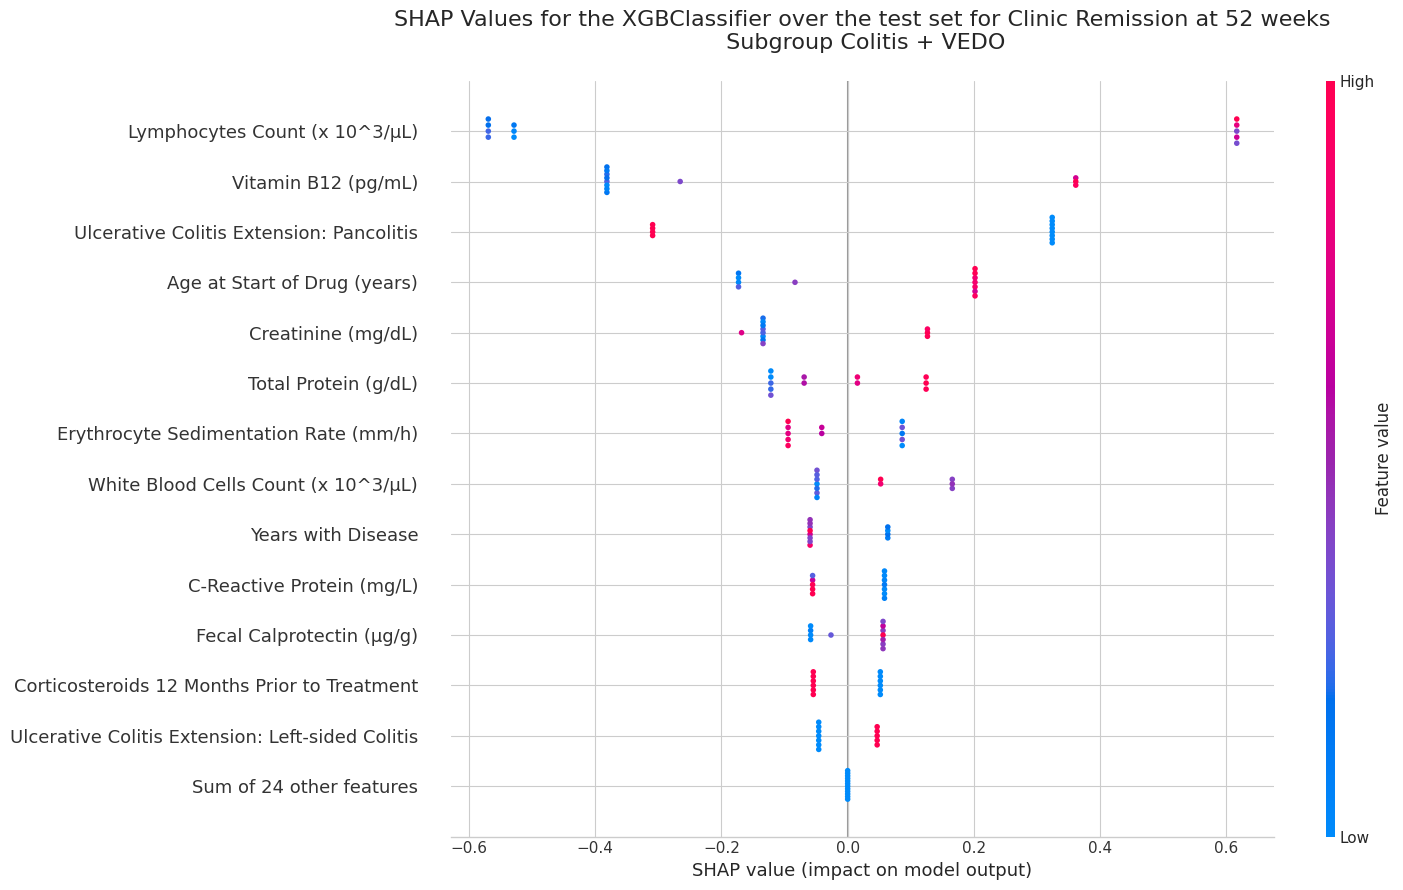

In [234]:
explainer = shap.Explainer(best_xgb_2)
shap_values = explainer(X_test_B)

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax = shap.plots.beeswarm(shap_values,  max_display=14, plot_size=(15, 9), show=False)

# Add a fig title
plt.title('SHAP Values for the XGBClassifier over the test set for Clinic Remission at 52 weeks\n Subgroup Colitis + VEDO\n', fontsize=16)
plt.tight_layout()
# Save the figure
plt.savefig('./output/models/shap_values_xgb_rem_clin_52_subgroup62.png')

# Plot the ax
plt.show()

## 6.3.Crohn's Disease + Ustekinumab 

In [235]:
df_to_table_C = df_to_table[(df_to_table['ibd_type'] == 'Crohn\'s disease') & (df_to_table['active_ingredient'] == 'Ustekinumab')]
X_C = X[(df_to_table['ibd_type'] == 'Crohn\'s disease') & (df_to_table['active_ingredient'] == 'Ustekinumab')]
y2_C = y2[(df_to_table['ibd_type'] == 'Crohn\'s disease') & (df_to_table['active_ingredient'] == 'Ustekinumab')]
y3_C = y3[(df_to_table['ibd_type'] == 'Crohn\'s disease') & (df_to_table['active_ingredient'] == 'Ustekinumab')]

### 6.3.1. Response at week 52

Clinical response at 52 weeks table one

In [236]:
table1_crohnuste_resclin52 = tableone_generator(df_to_table_C, 'clinical_response_52')
table1_crohnuste_resclin52.to_excel('./output/table1_crohn+uste_resclin52.xlsx')

display(table1_crohnuste_resclin52)

Grouped by clinical_response_52                                                                       
                                                                                                     Missing              Overall                   No                  Yes P-Value
n                                                                                                                             124                   20                  104        
Active Ingredient, n (%)                              Ustekinumab                                          0          124 (100.0)           20 (100.0)          104 (100.0)   1.000
Sex, n (%)                                            Female                                               0            68 (54.8)            11 (55.0)            57 (54.8)   1.000
                                                      Male                                                              56 (45.2)             9 (45.0)            47 (45.2)        
Family IBD Degree, n (%)                              First degree relative                                1            15 (12.2)             4 (20.0)            11 (10.7)   0.433
                                                      No relative                                                      104 (84.6)            15 (75.0)            89 (86.4)        
                                                      Second degree relative                                              4 (3.3)              1 (5.0)              3 (2.9)        
Crohn's Disease Location, n (%)                       Clonic                                               0            28 (22.6)             4 (20.0)            24 (23.1)   0.864
                                                      Ilear                                                             57 (46.0)            10 (50.0)            47 (45.2)        
                                                      Ileoclonic                                                        36 (29.0)             6 (30.0)            30 (28.8)        
                                                      Ileoclonic + Upper                                                  3 (2.4)                                   3 (2.9)        
Crohn's Disease Behavior, n (%)                       Fistulizing                                          0            24 (19.4)              1 (5.0)            23 (22.1)   0.001
                                                      Inflammatory                                                      54 (43.5)             4 (20.0)            50 (48.1)        
                                                      Stenosing                                                         46 (37.1)            15 (75.0)            31 (29.8)        
Ulcerative Colitis Extension, n (%)                   Another disease                                      0          124 (100.0)           20 (100.0)          104 (100.0)   1.000
IBD Type, n (%)                                       Crohn's disease                                      0          124 (100.0)           20 (100.0)          104 (100.0)   1.000
Previous TNF, n (%)                                   Yes                                                  0           108 (87.1)            17 (85.0)            91 (87.5)   0.722
                                                      No                                                                16 (12.9)             3 (15.0)            13 (12.5)        
Previous Ustekinumab, n (%)                           Yes                                                  0              1 (0.8)                                   1 (1.0)   1.000
                                                      No                                                               123 (99.2)           20 (100.0)           103 (99.0)        
Previous Vedolizumab, n (%)                           Yes                                                  0         


Fitting the RandomizedSearchCV
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
The best parameters are:
{'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 4, 'max_depth': 10, 'learning_rate': 0.15, 'gamma': 0.2, 'colsample_bytree': 1.0}

F1 Score: 0.9123
Precision: 0.8387
Recall: 1.0

Classification Report over the test set for res_clin_52:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.84      1.00      0.91        26

    accuracy                           0.84        31
   macro avg       0.42      0.50      0.46        31
weighted avg       0.70      0.84      0.77        31



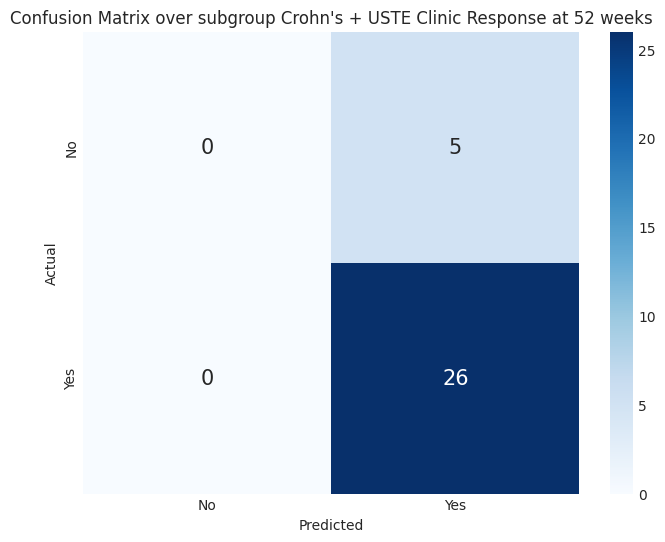

In [237]:
# Set the random seed for reproducibility
seed = 42

# Split the data into training and testing sets
X_train_C, X_test_C, y2_train_C, y2_test_C = train_test_split(X_C, y2_C, test_size=0.25, random_state=seed, stratify=y2_C)

# Perform the one-hot encoding
X_train_C = pd.get_dummies(X_train_C, drop_first=True)
X_test_C = pd.get_dummies(X_test_C, drop_first=True)

# Rename the columns
X_train_C = X_train_C.rename(columns=remap_col_names)
X_test_C = X_test_C.rename(columns=remap_col_names)

# Define the parameters for the RandomizedSearchCV
params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [1, 2, 3, 4, 5]
}

# Initialize the XGBClassifier
xgb = XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='logloss')

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=1000, scoring='f1', n_jobs=-1, cv=5, verbose=1, random_state=seed)

# Fit the RandomizedSearchCV
print('\nFitting the RandomizedSearchCV')
random_search.fit(X_train_C, y2_train_C)

# Get the best parameters
best_params = random_search.best_params_
print('The best parameters are:')
print(best_params)
# Initialize the XGBClassifier with the best parameters
best_xgb_2 = XGBClassifier(**best_params, random_state=seed, use_label_encoder=False, eval_metric='logloss')

# Fit the model
best_xgb_2.fit(X_train_C, y2_train_C)

# Predict the target variable
y2_pred_C = best_xgb_2.predict(X_test_C)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y2_test_C, y2_pred_C)

# Calculate the f1 score, precision, and recall
f1 = f1_score(y2_test_C, y2_pred_C)
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])

# Print the f1 score, precision, and recall
print('\nF1 Score:', np.round(f1, 4))
print('Precision:', np.round(precision, 4))
print('Recall:', np.round(recall, 4))

# Generate the classification report
print('\nClassification Report over the test set for res_clin_52:')
print(classification_report(y2_test_C, y2_pred_C))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'], annot_kws={"fontsize":15})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix over subgroup Crohn\'s + USTE Clinic Response at 52 weeks')
plt.show()

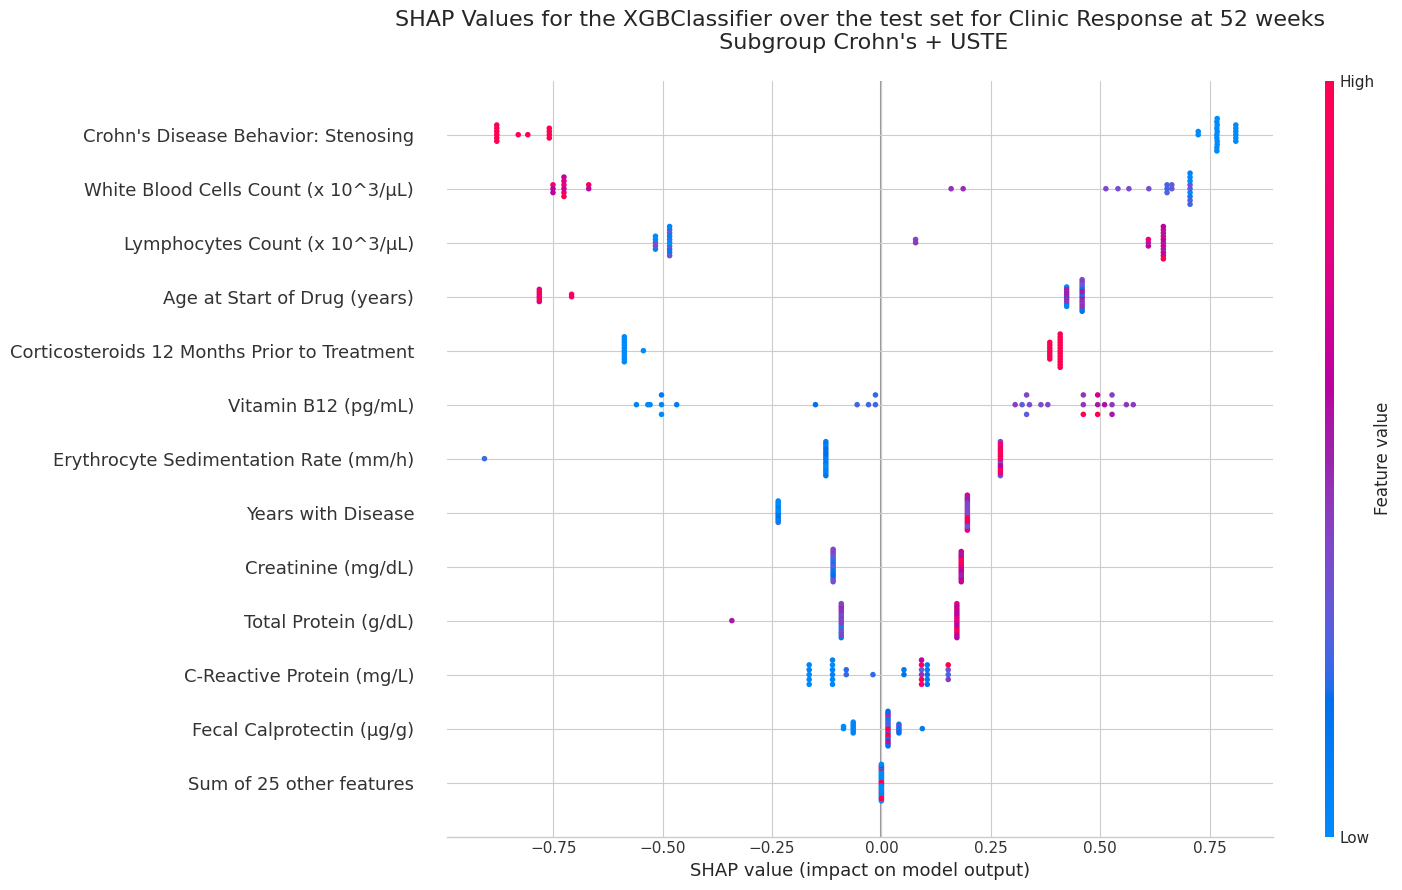

In [238]:
explainer = shap.Explainer(best_xgb_2)
shap_values = explainer(X_test_C)

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax = shap.plots.beeswarm(shap_values,  max_display=13, plot_size=(15, 9), show=False)

# Add a fig title
plt.title('SHAP Values for the XGBClassifier over the test set for Clinic Response at 52 weeks\n Subgroup Crohn\'s + USTE\n', fontsize=16)
plt.tight_layout()
# Save the figure
plt.savefig('./output/models/shap_values_xgb_res_clin_52_subgroup63.png')

# Plot the ax
plt.show()

### 6.3.2. Remission at week 52

Clinical remission at 52 weeks table one

In [239]:
table1_crohnuste_remclin52 = tableone_generator(df_to_table_C, 'clinical_remission_52')
table1_crohnuste_remclin52.to_excel('./output/table1_crohn+uste_remclin52.xlsx')

display(table1_crohnuste_remclin52)

Grouped by clinical_remission_52                                                                       
                                                                                                      Missing              Overall                   No                  Yes P-Value
n                                                                                                                              124                   58                   66        
Active Ingredient, n (%)                              Ustekinumab                                           0          124 (100.0)           58 (100.0)           66 (100.0)   1.000
Sex, n (%)                                            Female                                                0            68 (54.8)            37 (63.8)            31 (47.0)   0.090
                                                      Male                                                               56 (45.2)            21 (36.2)            35 (53.0)        
Family IBD Degree, n (%)                              First degree relative                                 1            15 (12.2)             7 (12.3)             8 (12.1)   0.684
                                                      No relative                                                       104 (84.6)            49 (86.0)            55 (83.3)        
                                                      Second degree relative                                               4 (3.3)              1 (1.8)              3 (4.5)        
Crohn's Disease Location, n (%)                       Clonic                                                0            28 (22.6)            11 (19.0)            17 (25.8)   0.574
                                                      Ilear                                                              57 (46.0)            26 (44.8)            31 (47.0)        
                                                      Ileoclonic                                                         36 (29.0)            20 (34.5)            16 (24.2)        
                                                      Ileoclonic + Upper                                                   3 (2.4)              1 (1.7)              2 (3.0)        
Crohn's Disease Behavior, n (%)                       Fistulizing                                           0            24 (19.4)            10 (17.2)            14 (21.2)   0.247
                                                      Inflammatory                                                       54 (43.5)            22 (37.9)            32 (48.5)        
                                                      Stenosing                                                          46 (37.1)            26 (44.8)            20 (30.3)        
Ulcerative Colitis Extension, n (%)                   Another disease                                       0          124 (100.0)           58 (100.0)           66 (100.0)   1.000
IBD Type, n (%)                                       Crohn's disease                                       0          124 (100.0)           58 (100.0)           66 (100.0)   1.000
Previous TNF, n (%)                                   Yes                                                   0           108 (87.1)            52 (89.7)            56 (84.8)   0.597
                                                      No                                                                 16 (12.9)             6 (10.3)            10 (15.2)        
Previous Ustekinumab, n (%)                           Yes                                                   0              1 (0.8)                                   1 (1.5)   1.000
                                                      No                                                                123 (99.2)           58 (100.0)            65 (98.5)        
Previous Vedolizumab, n (%)                           Yes                                      


Fitting the RandomizedSearchCV
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
The best parameters are:
{'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.6}

F1 Score: 0.7692
Precision: 0.6522
Recall: 0.9375

Classification Report over the test set for res_clin_52:
              precision    recall  f1-score   support

           0       0.88      0.47      0.61        15
           1       0.65      0.94      0.77        16

    accuracy                           0.71        31
   macro avg       0.76      0.70      0.69        31
weighted avg       0.76      0.71      0.69        31



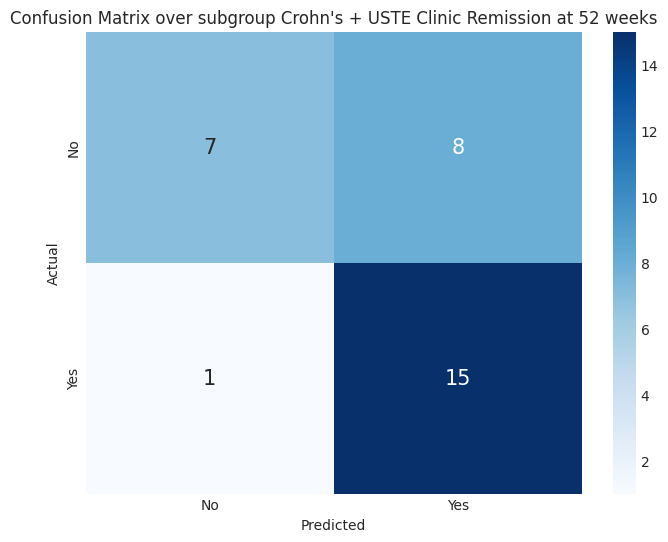

In [240]:
# Set the random seed for reproducibility
seed = 42

# Split the data into training and testing sets
X_train_C, X_test_C, y3_train_C, y3_test_C = train_test_split(X_C, y3_C, test_size=0.25, random_state=seed, stratify=y3_C)

# Perform the one-hot encoding
X_train_C = pd.get_dummies(X_train_C, drop_first=True)
X_test_C = pd.get_dummies(X_test_C, drop_first=True)

# Rename the columns
X_train_C = X_train_C.rename(columns=remap_col_names)
X_test_C = X_test_C.rename(columns=remap_col_names)

# Define the parameters for the RandomizedSearchCV
params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [1, 2, 3, 4, 5]
}

# Initialize the XGBClassifier
xgb = XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='logloss')

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=1000, scoring='f1', n_jobs=-1, cv=5, verbose=1, random_state=seed)

# Fit the RandomizedSearchCV
print('\nFitting the RandomizedSearchCV')
random_search.fit(X_train_C, y3_train_C)

# Get the best parameters
best_params = random_search.best_params_
print('The best parameters are:')
print(best_params)
# Initialize the XGBClassifier with the best parameters
best_xgb_2 = XGBClassifier(**best_params, random_state=seed, use_label_encoder=False, eval_metric='logloss')

# Fit the model
best_xgb_2.fit(X_train_C, y3_train_C)

# Predict the target variable
y3_pred_C = best_xgb_2.predict(X_test_C)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y3_test_C, y3_pred_C)

# Calculate the f1 score, precision, and recall
f1 = f1_score(y3_test_C, y3_pred_C)
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])

# Print the f1 score, precision, and recall
print('\nF1 Score:', np.round(f1, 4))
print('Precision:', np.round(precision, 4))
print('Recall:', np.round(recall, 4))

# Generate the classification report
print('\nClassification Report over the test set for res_clin_52:')
print(classification_report(y3_test_C, y3_pred_C))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'], annot_kws={"fontsize":15})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix over subgroup Crohn\'s + USTE Clinic Remission at 52 weeks')
plt.show()

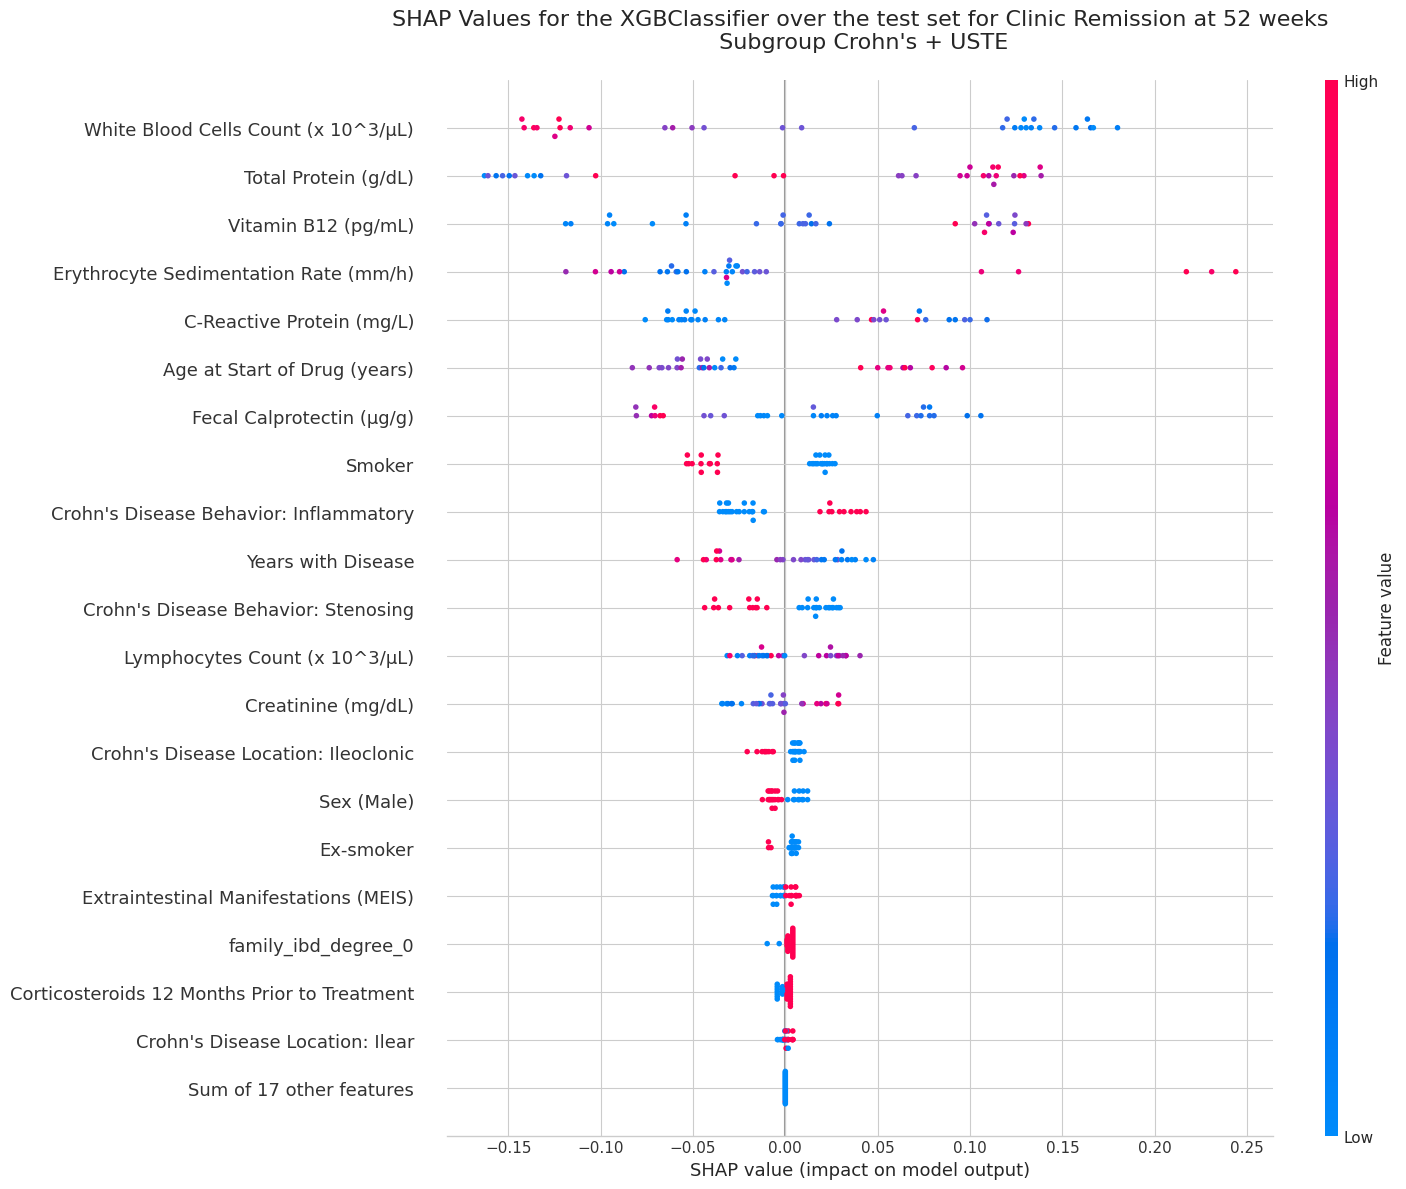

In [243]:
explainer = shap.Explainer(best_xgb_2)
shap_values = explainer(X_test_C)

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax = shap.plots.beeswarm(shap_values,  max_display=21, plot_size=(15, 12), show=False)

# Add a fig title
plt.title('SHAP Values for the XGBClassifier over the test set for Clinic Remission at 52 weeks\n Subgroup Crohn\'s + USTE\n', fontsize=16)
plt.tight_layout()
# Save the figure
plt.savefig('./output/models/shap_values_xgb_rem_clin_52_subgroup63.png')

# Plot the ax
plt.show()

## 6.4 Ulceralive Colitis + Ustekinumab

In [244]:
df_to_table_D = df_to_table[(df_to_table['ibd_type'] == 'Ulcerative colitis') & (df_to_table['active_ingredient'] == 'Ustekinumab')]
X_D = X[(df_to_table['ibd_type'] == 'Ulcerative colitis') & (df_to_table['active_ingredient'] == 'Ustekinumab')]
y2_D = y2[(df_to_table['ibd_type'] == 'Ulcerative colitis') & (df_to_table['active_ingredient'] == 'Ustekinumab')]
y3_D = y3[(df_to_table['ibd_type'] == 'Ulcerative colitis') & (df_to_table['active_ingredient'] == 'Ustekinumab')]

### 6.4.1. Response at week 52

Clinical response at 52 weeks table one

In [245]:
table1_coluste_resclin52 = tableone_generator(df_to_table_D, 'clinical_response_52')
table1_coluste_resclin52.to_excel('./output/table1_colitis+uste_resclin52.xlsx')

display(table1_coluste_resclin52)

Grouped by clinical_response_52                                                                             
                                                                                                     Missing                Overall                      No                   Yes P-Value
n                                                                                                                                11                       3                     8        
Active Ingredient, n (%)                              Ustekinumab                                          0             11 (100.0)               3 (100.0)             8 (100.0)   1.000
Sex, n (%)                                            Female                                               0               4 (36.4)                1 (33.3)              3 (37.5)   1.000
                                                      Male                                                                 7 (63.6)                2 (66.7)              5 (62.5)        
Family IBD Degree, n (%)                              No relative                                          1               9 (90.0)               3 (100.0)              6 (85.7)   1.000
                                                      Second degree relative                                               1 (10.0)                                      1 (14.3)        
Crohn's Disease Location, n (%)                       Another disease                                      0             11 (100.0)               3 (100.0)             8 (100.0)   1.000
Crohn's Disease Behavior, n (%)                       Another disease                                      0             11 (100.0)               3 (100.0)             8 (100.0)   1.000
Ulcerative Colitis Extension, n (%)                   Pancolitis                                           0               4 (36.4)                2 (66.7)              2 (25.0)   0.273
                                                      Proctitis                                                            3 (27.3)                1 (33.3)              2 (25.0)        
                                                      Left-sided colitis                                                   4 (36.4)                                      4 (50.0)        
IBD Type, n (%)                                       Ulcerative colitis                                   0             11 (100.0)               3 (100.0)             8 (100.0)   1.000
Previous TNF, n (%)                                   Yes                                                  0               8 (72.7)                2 (66.7)              6 (75.0)   1.000
                                                      No                                                                   3 (27.3)                1 (33.3)              2 (25.0)        
Previous Ustekinumab, n (%)                           No                                                   0             11 (100.0)               3 (100.0)             8 (100.0)   1.000
Previous Vedolizumab, n (%)                           Yes                                                  0               4 (36.4)                1 (33.3)              3 (37.5)   1.000
                                                      No                                                                   7 (63.6)                2 (66.7)              5 (62.5)        
Smoking Status, n (%)                                 Non-smoker                                           0               8 (72.7)               3 (100.0)              5 (62.5)   0.491
                                                      Ex-smoker                                                            3 (27.3)                                      3 (37.5)        
Extraintestinal Manifestations (MEIS), n (%)          Yes                                                  0               4 (36.4)                2 (66.7)              2 


Fitting the RandomizedSearchCV
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
The best parameters are:
{'subsample': 0.7, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.8}

F1 Score: 0.8
Precision: 0.6667
Recall: 1.0

Classification Report over the test set for res_clin_52:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.67      1.00      0.80         2

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



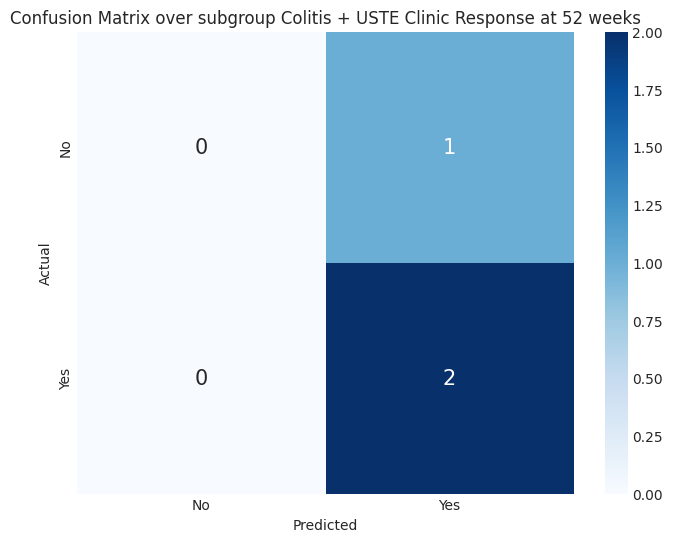

In [246]:
# Set the random seed for reproducibility
seed = 42

# Split the data into training and testing sets
X_train_D, X_test_D, y2_train_D, y2_test_D = train_test_split(X_D, y2_D, test_size=0.25, random_state=seed, stratify=y2_D)

# Perform the one-hot encoding
X_train_D = pd.get_dummies(X_train_D, drop_first=True)
X_test_D = pd.get_dummies(X_test_D, drop_first=True)

# Rename the columns
X_train_D = X_train_D.rename(columns=remap_col_names)
X_test_D = X_test_D.rename(columns=remap_col_names)

# Define the parameters for the RandomizedSearchCV
params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [1, 2, 3, 4, 5]
}

# Initialize the XGBClassifier
xgb = XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='logloss')

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=1000, scoring='f1', n_jobs=-1, cv=5, verbose=1, random_state=seed)

# Fit the RandomizedSearchCV
print('\nFitting the RandomizedSearchCV')
random_search.fit(X_train_D, y2_train_D)

# Get the best parameters
best_params = random_search.best_params_
print('The best parameters are:')
print(best_params)
# Initialize the XGBClassifier with the best parameters
best_xgb_2 = XGBClassifier(**best_params, random_state=seed, use_label_encoder=False, eval_metric='logloss')

# Fit the model
best_xgb_2.fit(X_train_D, y2_train_D)

# Predict the target variable
y2_pred_D = best_xgb_2.predict(X_test_D)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y2_test_D, y2_pred_D)

# Calculate the f1 score, precision, and recall
f1 = f1_score(y2_test_D, y2_pred_D)
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])

# Print the f1 score, precision, and recall
print('\nF1 Score:', np.round(f1, 4))
print('Precision:', np.round(precision, 4))
print('Recall:', np.round(recall, 4))

# Generate the classification report
print('\nClassification Report over the test set for res_clin_52:')
print(classification_report(y2_test_D, y2_pred_D))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'], annot_kws={"fontsize":15})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix over subgroup Colitis + USTE Clinic Response at 52 weeks')
plt.show()

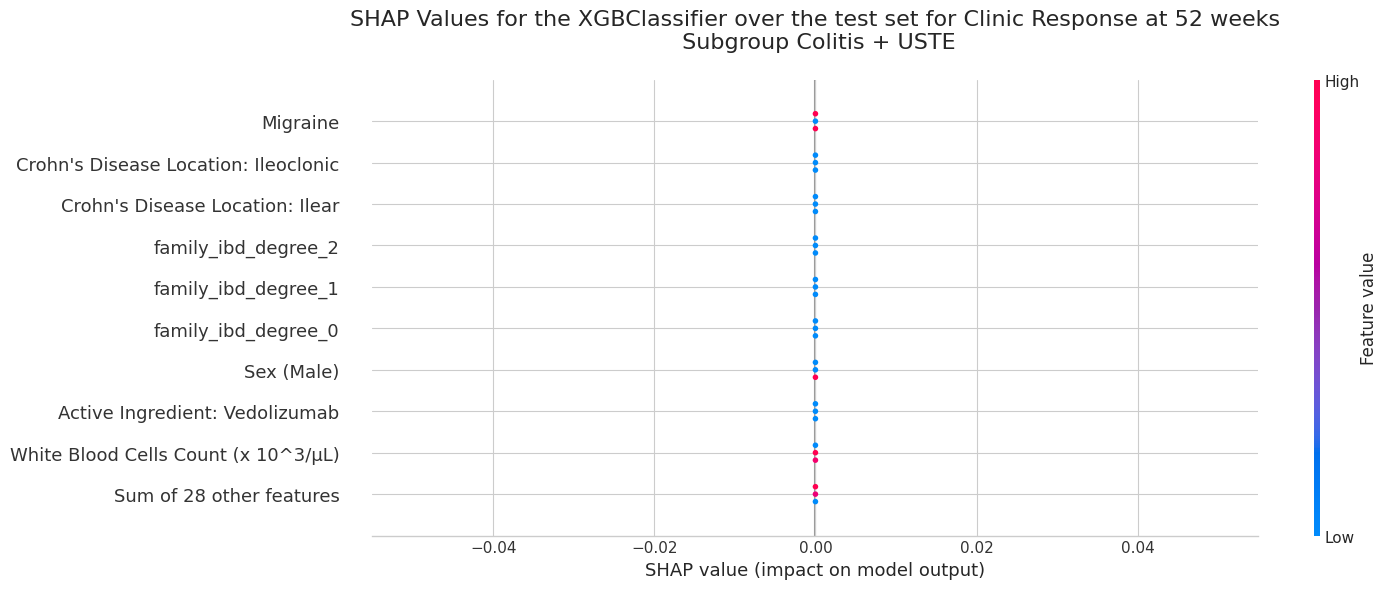

In [249]:
explainer = shap.Explainer(best_xgb_2)
shap_values = explainer(X_test_D)

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax = shap.plots.beeswarm(shap_values,  max_display=10, plot_size=(15, 6), show=False)

# Add a fig title
plt.title('SHAP Values for the XGBClassifier over the test set for Clinic Response at 52 weeks\n Subgroup Colitis + USTE\n', fontsize=16)
plt.tight_layout()
# Save the figure
plt.savefig('./output/models/shap_values_xgb_res_clin_52_subgroup64.png')

# Plot the ax
plt.show()

### 6.4.2. Remission at week 52

Clinical remission at 52 weeks table one

In [250]:
table1_coluste_remclin52 = tableone_generator(df_to_table_D, 'clinical_remission_52')
table1_coluste_remclin52.to_excel('./output/table1_colitis+uste_remclin52.xlsx')

display(table1_coluste_remclin52)

Grouped by clinical_remission_52                                                                             
                                                                                                      Missing                Overall                      No                   Yes P-Value
n                                                                                                                                 11                       7                     4        
Active Ingredient, n (%)                              Ustekinumab                                           0             11 (100.0)               7 (100.0)             4 (100.0)   1.000
Sex, n (%)                                            Female                                                0               4 (36.4)                2 (28.6)              2 (50.0)   0.576
                                                      Male                                                                  7 (63.6)                5 (71.4)              2 (50.0)        
Family IBD Degree, n (%)                              No relative                                           1               9 (90.0)                6 (85.7)             3 (100.0)   1.000
                                                      Second degree relative                                                1 (10.0)                1 (14.3)                              
Crohn's Disease Location, n (%)                       Another disease                                       0             11 (100.0)               7 (100.0)             4 (100.0)   1.000
Crohn's Disease Behavior, n (%)                       Another disease                                       0             11 (100.0)               7 (100.0)             4 (100.0)   1.000
Ulcerative Colitis Extension, n (%)                   Left-sided colitis                                    0               4 (36.4)                3 (42.9)              1 (25.0)   0.757
                                                      Pancolitis                                                            4 (36.4)                2 (28.6)              2 (50.0)        
                                                      Proctitis                                                             3 (27.3)                2 (28.6)              1 (25.0)        
IBD Type, n (%)                                       Ulcerative colitis                                    0             11 (100.0)               7 (100.0)             4 (100.0)   1.000
Previous TNF, n (%)                                   Yes                                                   0               8 (72.7)                4 (57.1)             4 (100.0)   0.236
                                                      No                                                                    3 (27.3)                3 (42.9)                              
Previous Ustekinumab, n (%)                           No                                                    0             11 (100.0)               7 (100.0)             4 (100.0)   1.000
Previous Vedolizumab, n (%)                           Yes                                                   0               4 (36.4)                3 (42.9)              1 (25.0)   1.000
                                                      No                                                                    7 (63.6)                4 (57.1)              3 (75.0)        
Smoking Status, n (%)                                 Non-smoker                                            0               8 (72.7)                5 (71.4)              3 (75.0)   1.000
                                                      Ex-smoker                                                             3 (27.3)                2 (28.6)              1 (25.0)        
Extraintestinal Manifestations (MEIS), n (%)          Yes                                                   0               4 (36.4)                3 


Fitting the RandomizedSearchCV
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


/home/juanluisgonzalez/FPS_proyects/EII/.venv/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/juanluisgonzalez/FPS_proyects/EII/.venv/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/juanluisgonzalez/FPS_proyects/EII/.venv/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

The best parameters are:
{'subsample': 0.7, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.8}

F1 Score: 0.0
Precision: nan
Recall: 0.0

Classification Report over the test set for res_clin_52:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



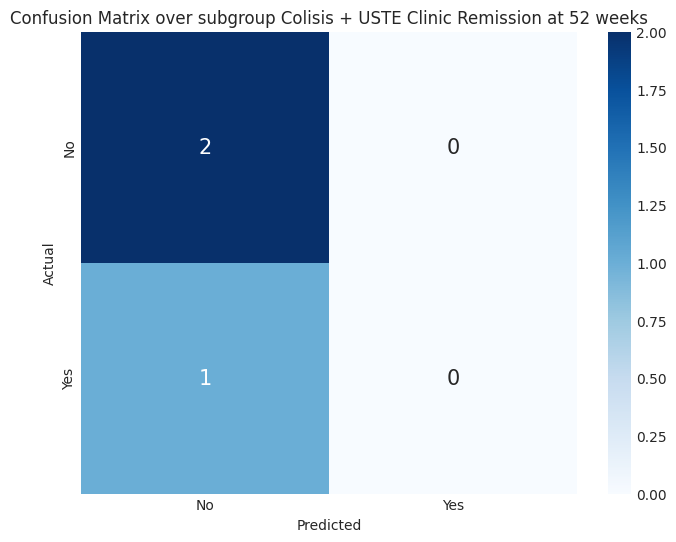

In [251]:
# Set the random seed for reproducibility
seed = 42

# Split the data into training and testing sets
X_train_D, X_test_D, y3_train_D, y3_test_D = train_test_split(X_D, y3_D, test_size=0.25, random_state=seed, stratify=y3_D)

# Perform the one-hot encoding
X_train_D = pd.get_dummies(X_train_D, drop_first=True)
X_test_D = pd.get_dummies(X_test_D, drop_first=True)

# Rename the columns
X_train_D = X_train_D.rename(columns=remap_col_names)
X_test_D = X_test_D.rename(columns=remap_col_names)

# Define the parameters for the RandomizedSearchCV
params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [1, 2, 3, 4, 5]
}

# Initialize the XGBClassifier
xgb = XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='logloss')

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=1000, scoring='f1', n_jobs=-1, cv=5, verbose=1, random_state=seed)

# Fit the RandomizedSearchCV
print('\nFitting the RandomizedSearchCV')
random_search.fit(X_train_D, y3_train_D)

# Get the best parameters
best_params = random_search.best_params_
print('The best parameters are:')
print(best_params)
# Initialize the XGBClassifier with the best parameters
best_xgb_2 = XGBClassifier(**best_params, random_state=seed, use_label_encoder=False, eval_metric='logloss')

# Fit the model
best_xgb_2.fit(X_train_D, y3_train_D)

# Predict the target variable
y3_pred_D = best_xgb_2.predict(X_test_D)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y3_test_D, y3_pred_D)

# Calculate the f1 score, precision, and recall
f1 = f1_score(y3_test_D, y3_pred_D)
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])

# Print the f1 score, precision, and recall
print('\nF1 Score:', np.round(f1, 4))
print('Precision:', np.round(precision, 4))
print('Recall:', np.round(recall, 4))

# Generate the classification report
print('\nClassification Report over the test set for res_clin_52:')
print(classification_report(y3_test_D, y3_pred_D))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'], annot_kws={"fontsize":15})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix over subgroup Colisis + USTE Clinic Remission at 52 weeks')
plt.show()

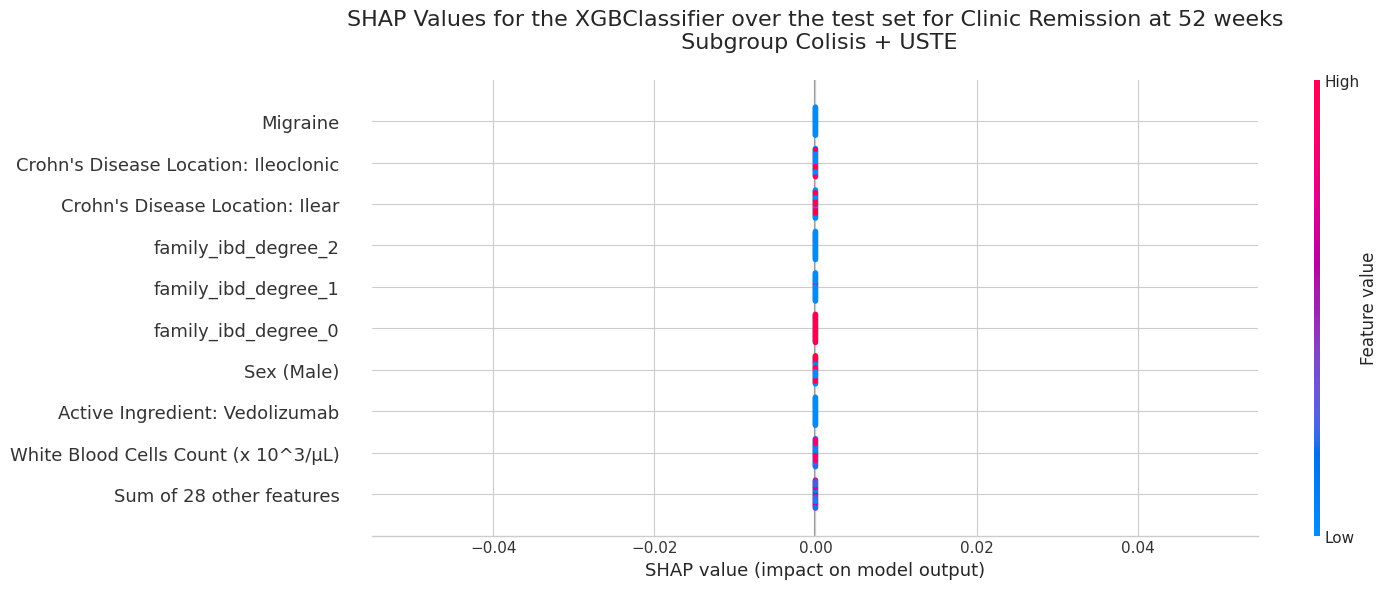

In [253]:
explainer = shap.Explainer(best_xgb_2)
shap_values = explainer(X_test_C)

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax = shap.plots.beeswarm(shap_values,  max_display=10, plot_size=(15, 6), show=False)

# Add a fig title
plt.title('SHAP Values for the XGBClassifier over the test set for Clinic Remission at 52 weeks\n Subgroup Colisis + USTE\n', fontsize=16)
plt.tight_layout()
# Save the figure
plt.savefig('./output/models/shap_values_xgb_rem_clin_52_subgroup64.png')

# Plot the ax
plt.show()